# Running processes same as DataWrangling11 on all counties available in US

# Clean up new added datasets unemployment rates, poverty rate, education and vehicle

# Importing libraries

In [586]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib

from IPython.core.display import display

# pd.set_option('display.max_columns', None)
# pd.reset_optio('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

# Load data and constants

In [587]:
daily_aqi_by_county_2017 = pd.read_csv('../../data/raw/daily_aqi_by_county_2017.csv')
daily_aqi_by_county_2018 = pd.read_csv('../../data/raw/daily_aqi_by_county_2018.csv')
daily_aqi_by_county_2019 = pd.read_csv('../../data/raw/daily_aqi_by_county_2019.csv')

county_demographic = pd.read_csv('../../data/raw/county_cc-est2019-alldata.csv', encoding='latin-1')

unemployment = pd.read_excel('../../data/raw/Unemployment.xls', header=None, sheet_name=0)

# Small area income and poverty estimates
saipe2017 = pd.read_excel('../../data/raw/saipe_economic/est17all.xls')
saipe2018 = pd.read_excel('../../data/raw/saipe_economic/est18all.xls')
saipe2019 = pd.read_excel('../../data/raw/saipe_economic/est19all.xls')

educ_vehicle_2017 = pd.read_csv('../../data/processed/acs1_edu_vehicle2017.csv')
educ_vehicle_2018 = pd.read_csv('../../data/processed/acs1_edu_vehicle2018.csv')
educ_vehicle_2019 = pd.read_csv('../../data/processed/acs1_edu_vehicle2019.csv')

annual_income_by_county = pd.read_csv('../../data/raw/CAINC1__ALL_AREAS_1969_2019.csv', encoding='latin-1')


In [588]:
def remove_col(df, col_name):
    '''Returns a dataframe with removed column or columns from old dataframe'''
    new_df = df.copy()

    if(type(col_name) != str and len(col_name) > 1):
        for index in col_name:
            new_df = new_df.drop(str(index), axis=1)
    else:
        new_df = new_df.drop(str(col_name), axis=1)
    return new_df

def get_df_with_geofips(df, state_code, county_code):
    ''' Returns dataframe with geofips column '''
    state_code = df[state_code].astype(str).values
    county_code = df[county_code].astype(str).values

    geofips = []
    for stateID, countyID in zip(state_code, county_code):
        id = ''
        stateLen = len(stateID)
        countyLen = len(countyID)
        if(stateLen < 2):
            id += '0' + stateID
        else:
            id += stateID
        if(countyLen == 1):
            id += '00' + countyID
        elif(countyLen == 2):
            id += '0' + countyID
        else:
            id += countyID
        geofips.append(id)

    df.insert(loc=0, column='GeoFIPS', value=geofips)
    return df

## Clean up and set up income datasets


In [589]:
annual_income_by_county

all_incomes_2017_2019 = remove_col(annual_income_by_county, range(1969, 2017))

# used to remove last 4 rows as they are not index data; looks like extra info
all_incomes_2017_2019 = all_incomes_2017_2019[:len(all_incomes_2017_2019) - 4]

# all_incomes_2017_2019.info()
all_incomes_2017_2019

,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019
0,"""00000""",United States,,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,16937582000,17839255000,18542262000
1,"""00000""",United States,,CAINC1,2.0,...,Population (persons) 1/,Number of persons,324985539,326687501,328239523
2,"""00000""",United States,,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,52118,54606,56490
3,"""01000""",Alabama,5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,199999756,208752683,216449038
4,"""01000""",Alabama,5,CAINC1,2.0,...,Population (persons) 1/,Number of persons,4874486,4887681,4903185
...,...,...,...,...,...,...,...,...,...,...,...
9589,"""97000""",Rocky Mountain,7,CAINC1,2.0,...,Population (persons) 1/,Number of persons,12062055,12233639,12399296
9590,"""97000""",Rocky Mountain,7,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,49991,52936,54873
9591,"""98000""",Far West,8,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,3279057722,3472097346,3634009401
9592,"""98000""",Far West,8,CAINC1,2.0,...,Population (persons) 1/,Number of persons,56059482,56350416,56572426


* Years 1969 to 2016 were removed as we only have interest on 2017-2019
* Also last four rows were remoed as they were not row data, there were just caption text


In [590]:
all_incomes_2017_2019['2017'] = pd.to_numeric(all_incomes_2017_2019['2017'], downcast='float', errors='coerce')
all_incomes_2017_2019['2018'] = pd.to_numeric(all_incomes_2017_2019['2018'], downcast='float', errors='coerce')
all_incomes_2017_2019['2019'] = pd.to_numeric(all_incomes_2017_2019['2019'], downcast='float', errors='coerce')

# all_incomes_2017_2019 = remove_col(all_incomes_2017_2019, range(2017,2020))
all_incomes_2017_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9594 entries, 0 to 9593
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GeoFIPS                 9594 non-null   object 
 1   GeoName                 9594 non-null   object 
 2   Region                  9594 non-null   object 
 3   TableName               9594 non-null   object 
 4   LineCode                9594 non-null   float64
 5   IndustryClassification  9594 non-null   object 
 6   Description             9594 non-null   object 
 7   Unit                    9594 non-null   object 
 8   2017                    9519 non-null   float32
 9   2018                    9519 non-null   float32
 10  2019                    9519 non-null   float32
dtypes: float32(3), float64(1), object(7)
memory usage: 712.2+ KB


* Columns were changed to appropriate types
* Income was changed to type float
* 'NA' string was changed to np.nan
** Rename column income data to be more descriptive and remove old column in place of new column names

In [591]:
personal_income = all_incomes_2017_2019['Description'] == ('Personal income (thousands of dollars)')
per_capita_personal_income = all_incomes_2017_2019['Description'] == ('Per capita personal income (dollars) 2/')
county_personal_incomes = all_incomes_2017_2019[personal_income]
county_per_capita_personal_income = all_incomes_2017_2019[per_capita_personal_income]
county_personal_incomes.rename(columns={'2017':'Personal income (thousands of dollars) 2017',
                                        '2018':'Personal income (thousands of dollars) 2018',
                                        '2019':'Personal income (thousands of dollars) 2019',}, inplace=True)
county_per_capita_personal_income.rename(columns={'2017':'Per capita personal income (dollars) 2017',
                                                  '2018':'Per capita personal income (dollars) 2018',
                                                  '2019':'Per capita personal income (dollars) 2019',}, inplace=True)

display(county_personal_incomes)
display(county_per_capita_personal_income)

/home/wkc/.local/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,Personal income (thousands of dollars) 2017,Personal income (thousands of dollars) 2018,Personal income (thousands of dollars) 2019
0,"""00000""",United States,,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,1.693758e+10,1.783926e+10,1.854226e+10
3,"""01000""",Alabama,5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,1.999998e+08,2.087527e+08,2.164490e+08
6,"""01001""","Autauga, AL",5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,2.276561e+06,2.360366e+06,2.453617e+06
9,"""01003""","Baldwin, AL",5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,9.471242e+06,1.006597e+07,1.060026e+07
12,"""01005""","Barbour, AL",5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,8.381840e+05,8.721890e+05,8.828340e+05
...,...,...,...,...,...,...,...,...,...,...,...
9579,"""94000""",Plains,4,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,1.055029e+09,1.107630e+09,1.146515e+09
9582,"""95000""",Southeast,5,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,3.818755e+09,4.022276e+09,4.173677e+09
9585,"""96000""",Southwest,6,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,1.924648e+09,2.051027e+09,2.144764e+09
9588,"""97000""",Rocky Mountain,7,CAINC1,1.0,...,Personal income (thousands of dollars),Thousands of dollars,6.029942e+08,6.476007e+08,6.803901e+08


,GeoFIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,Per capita personal income (dollars) 2017,Per capita personal income (dollars) 2018,Per capita personal income (dollars) 2019
2,"""00000""",United States,,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,52118.0,54606.0,56490.0
5,"""01000""",Alabama,5,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,41030.0,42710.0,44145.0
8,"""01001""","Autauga, AL",5,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,41101.0,42504.0,43917.0
11,"""01003""","Baldwin, AL",5,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,44566.0,46205.0,47485.0
14,"""01005""","Barbour, AL",5,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,33318.0,35067.0,35763.0
...,...,...,...,...,...,...,...,...,...,...,...
9581,"""94000""",Plains,4,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,49609.0,51879.0,53509.0
9584,"""95000""",Southeast,5,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,45657.0,47715.0,49159.0
9587,"""96000""",Southwest,6,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,46531.0,49045.0,50670.0
9590,"""97000""",Rocky Mountain,7,CAINC1,3.0,...,Per capita personal income (dollars) 2/,Dollars,49991.0,52936.0,54873.0


In [592]:
cols_to_remove = ['IndustryClassification', 'TableName', 'Unit', 'Description', 'LineCode', 'Region']

county_personal_incomes.drop(cols_to_remove, axis=1, inplace=True)
county_per_capita_personal_income.drop(cols_to_remove, axis=1, inplace=True)

county_incomes = pd.merge(county_personal_incomes, county_per_capita_personal_income, how='inner')
county_incomes

/home/wkc/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,GeoFIPS,GeoName,Personal income (thousands of dollars) 2017,Personal income (thousands of dollars) 2018,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2017,Per capita personal income (dollars) 2018,Per capita personal income (dollars) 2019
0,"""00000""",United States,1.693758e+10,1.783926e+10,1.854226e+10,52118.0,54606.0,56490.0
1,"""01000""",Alabama,1.999998e+08,2.087527e+08,2.164490e+08,41030.0,42710.0,44145.0
2,"""01001""","Autauga, AL",2.276561e+06,2.360366e+06,2.453617e+06,41101.0,42504.0,43917.0
3,"""01003""","Baldwin, AL",9.471242e+06,1.006597e+07,1.060026e+07,44566.0,46205.0,47485.0
4,"""01005""","Barbour, AL",8.381840e+05,8.721890e+05,8.828340e+05,33318.0,35067.0,35763.0
...,...,...,...,...,...,...,...,...
3193,"""94000""",Plains,1.055029e+09,1.107630e+09,1.146515e+09,49609.0,51879.0,53509.0
3194,"""95000""",Southeast,3.818755e+09,4.022276e+09,4.173677e+09,45657.0,47715.0,49159.0
3195,"""96000""",Southwest,1.924648e+09,2.051027e+09,2.144764e+09,46531.0,49045.0,50670.0
3196,"""97000""",Rocky Mountain,6.029942e+08,6.476007e+08,6.803901e+08,49991.0,52936.0,54873.0


Removed redundant or uninterested columns
* remove more columns
* remove IndustryClassifaction as it only contains ... values and also not what we are interested in
* remove TableName as only one value and not what we are interested in
* remove Unit as that has the same value as Thousands of dollars
* remove Description as that is all personal income now
* remove LineCode as there are no unique values all value is 1
* remove Region as not interested in this data

In [593]:
county_incomes['GeoFIPS'] = county_incomes['GeoFIPS'].str.strip('" "')
county_incomes

,GeoFIPS,GeoName,Personal income (thousands of dollars) 2017,Personal income (thousands of dollars) 2018,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2017,Per capita personal income (dollars) 2018,Per capita personal income (dollars) 2019
0,00000,United States,1.693758e+10,1.783926e+10,1.854226e+10,52118.0,54606.0,56490.0
1,01000,Alabama,1.999998e+08,2.087527e+08,2.164490e+08,41030.0,42710.0,44145.0
2,01001,"Autauga, AL",2.276561e+06,2.360366e+06,2.453617e+06,41101.0,42504.0,43917.0
3,01003,"Baldwin, AL",9.471242e+06,1.006597e+07,1.060026e+07,44566.0,46205.0,47485.0
4,01005,"Barbour, AL",8.381840e+05,8.721890e+05,8.828340e+05,33318.0,35067.0,35763.0
...,...,...,...,...,...,...,...,...
3193,94000,Plains,1.055029e+09,1.107630e+09,1.146515e+09,49609.0,51879.0,53509.0
3194,95000,Southeast,3.818755e+09,4.022276e+09,4.173677e+09,45657.0,47715.0,49159.0
3195,96000,Southwest,1.924648e+09,2.051027e+09,2.144764e+09,46531.0,49045.0,50670.0
3196,97000,Rocky Mountain,6.029942e+08,6.476007e+08,6.803901e+08,49991.0,52936.0,54873.0


* remove "" characters from income dataset


In [594]:

county_incomes_2017_2019 = county_incomes
# county_incomes_2017_2019['GeoFIPS'] = pd.to_numeric(county_incomes_2017_2019['GeoFIPS'])
county_incomes_2017_2019

,GeoFIPS,GeoName,Personal income (thousands of dollars) 2017,Personal income (thousands of dollars) 2018,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2017,Per capita personal income (dollars) 2018,Per capita personal income (dollars) 2019
0,00000,United States,1.693758e+10,1.783926e+10,1.854226e+10,52118.0,54606.0,56490.0
1,01000,Alabama,1.999998e+08,2.087527e+08,2.164490e+08,41030.0,42710.0,44145.0
2,01001,"Autauga, AL",2.276561e+06,2.360366e+06,2.453617e+06,41101.0,42504.0,43917.0
3,01003,"Baldwin, AL",9.471242e+06,1.006597e+07,1.060026e+07,44566.0,46205.0,47485.0
4,01005,"Barbour, AL",8.381840e+05,8.721890e+05,8.828340e+05,33318.0,35067.0,35763.0
...,...,...,...,...,...,...,...,...
3193,94000,Plains,1.055029e+09,1.107630e+09,1.146515e+09,49609.0,51879.0,53509.0
3194,95000,Southeast,3.818755e+09,4.022276e+09,4.173677e+09,45657.0,47715.0,49159.0
3195,96000,Southwest,1.924648e+09,2.051027e+09,2.144764e+09,46531.0,49045.0,50670.0
3196,97000,Rocky Mountain,6.029942e+08,6.476007e+08,6.803901e+08,49991.0,52936.0,54873.0


# Clean up Unemployment Data


In [595]:
display(unemployment)
unemployment2017_2019 = unemployment[4:]
unemployment2017_2019.reset_index(drop=True, inplace=True)
unemployment_header = unemployment2017_2019.iloc[0, :].values
unemployment2017_2019.columns = unemployment_header
unemployment2017_2019 = unemployment2017_2019.drop([0])
display(unemployment2017_2019)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
0,Unemployment and median household income for t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sources: Unemployment: U.S. Department of Labo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"For definitions of rural classifications, see ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"This table was prepared by USDA, Economic Rese...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fips_txt,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,Unemployment_rate_2008,Civilian_labor_force_2009,Employed_2009,Unemployed_2009,Unemployment_rate_2009,Civilian_labor_force_2010,Employed_2010,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3275,72145,PR,"Vega Baja Municipio, PR

,fips_txt,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,Unemployment_rate_2008,Civilian_labor_force_2009,Employed_2009,Unemployed_2009,Unemployment_rate_2009,Civilian_labor_force_2010,Employed_2010,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
1,00000,US,United States,NaN,NaN,NaN,142601667,136904680,5696987,3.99504,143786778,136978129,6808649,4.73524,144839532,136455911,8383621,5.78821,145660181,136944540,8715641,5.98354,146725005,138614038,8110967,5.52801,148012786,140462401,7550385,5.10117,150223730,143262292,6961438,4.63405,152191286,145156247,7035039,4.6225,153761298,144860522,8900776,5.7887,153825791,139594849,14230942,9.25134,154270726,139408198,14862528,9.63406,154606324,140765822,13840502,8.95209,155119209,142600412,12518797,8.07044,155485689,144018150,11467539,7.3753,155957310,146338323,9618987,6.16771,156798981,148515185,8283796,5.28307,158626135,150902618,7723517,4.86901,160158564,153183461,6975103,4.35512,161389026,155102319,6286707,3.89537,163100055,157115247,5984808,3.66941,65712,NaN
2,01000,AL,Alabama,NaN,NaN,NaN,2133223,2035594,97629,4.6,2115401,2006884,108517,5.1,2106161,1981919,124242,5.9,2120225,1992732,127493,6,2136458,2014889,121569,5.7,2146025,2049791,96234,4.5,2167809,2080233,87576,4,2175612,2089127,86485,4,2176489,2053477,123012,5.7,2162999,1924747,238252,11,2196042,1964559,231483,10.5,2202670,1990413,212257,9.6,2176337,2003290,173047,8,2174000,2017043,156957,7.2,2160842,2014290,146552,6.8,2161481,2030005,131476,6.1,2182558,2055251,127307,5.8,2186869,2090373,96496,4.4,2216627,2130845,85782,3.9,2241747,2174483,67264,3,51771,100
3,01001,AL,"Autauga County, AL",2,2,1,21720,20846,874,4,21955,21055,900,4.1,22094,21035,1059,4.8,22604,21462,1142,5.1,23218,22103,1115,4.8,23949,23037,912,3.8,24398,23585,813,3.3,24383,23577,806,3.3,24687,23420,1267,5.1,24703,22301,2402,9.7,25713,23431,2282,8.9,25836,23677,2159,8.4,25740,23961,1779,6.9,25810,24205,1605,6.2,25592,24097,1495,5.8,25652,24321,1331,5.2,26031,24709,1322,5.1,26075,25062,1013,3.9,26196,25261,935,3.6,26172,25458,714,2.7,58233,112.482
4,01003,AL,"Baldwin County, AL",3,2,1,69533,66971,2562,3.7,69161,66195,2966,4.3,69169,65691,3478,5,72299,68702,3597,5,74772,70919,3853,5.2,76804,73743,3061,4,79711,77147,2564,3.2,82659,80099,2560,3.1,83223,79372,3851,4.6,82451,74403,8048,9.8,83459,75120,8339,10,85045,77418,7627,9,84414,78065,6349,7.5,85280,79626,5654,6.6,86384,81083,5301,6.1,87872,83010,4862,5.5,90895,86060,4835,5.3,92456,88711,3745,4.1,95233,91809,3424,3.6,97328,94675,2653,2.7,59871,115

* fix header columns of csv file
* remove empty rows

In [596]:
# used to remove other year data to keep only 2017-2019
display(unemployment2017_2019.columns)
cols_to_remove = unemployment2017_2019.iloc[:, 3:74].columns
unemployment2017_2019 = remove_col(unemployment2017_2019, cols_to_remove)


# unemployment2017_2019

Index(['fips_txt', 'Stabr', 'area_name', 'Rural_urban_continuum_code_2013',
       'Urban_influence_code_2013', 'Metro_2013', 'Civilian_labor_force_2000',
       'Employed_2000', 'Unemployed_2000', 'Unemployment_rate_2000',
       'Civilian_labor_force_2001', 'Employed_2001', 'Unemployed_2001',
       'Unemployment_rate_2001', 'Civilian_labor_force_2002', 'Employed_2002',
       'Unemployed_2002', 'Unemployment_rate_2002',
       'Civilian_labor_force_2003', 'Employed_2003', 'Unemployed_2003',
       'Unemployment_rate_2003', 'Civilian_labor_force_2004', 'Employed_2004',
       'Unemployed_2004', 'Unemployment_rate_2004',
       'Civilian_labor_force_2005', 'Employed_2005', 'Unemployed_2005',
       'Unemployment_rate_2005', 'Civilian_labor_force_2006', 'Employed_2006',
       'Unemployed_2006', 'Unemployment_rate_2006',
       'Civilian_labor_force_2007', 'Employed_2007', 'Unemployed_2007',
       'Unemployment_rate_2007', 'Civilian_labor_force_2008', 'Employed_2008',
       'Unemploy

In [597]:
unemployment_rates_2017_2019 = unemployment2017_2019.iloc[:,:-2]
display(unemployment_rates_2017_2019)

,fips_txt,Stabr,area_name,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019
1,00000,US,United States,160158564,153183461,6975103,4.35512,161389026,155102319,6286707,3.89537,163100055,157115247,5984808,3.66941
2,01000,AL,Alabama,2186869,2090373,96496,4.4,2216627,2130845,85782,3.9,2241747,2174483,67264,3
3,01001,AL,"Autauga County, AL",26075,25062,1013,3.9,26196,25261,935,3.6,26172,25458,714,2.7
4,01003,AL,"Baldwin County, AL",92456,88711,3745,4.1,95233,91809,3424,3.6,97328,94675,2653,2.7
5,01005,AL,"Barbour County, AL",8349,7863,486,5.8,8414,7987,427,5.1,8537,8213,324,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,72145,PR,"Vega Baja Municipio, PR",13414,11746,1668,12.4,13117,11750,1367,10.4,13037,11791,1246,9.6
3272,72147,PR,"Vieques Municipio, PR",3027,2589,438,14.5,2718,2269,449,16.5,2585,2406,179,6.9
3273,72149,PR,"Villalba Municipio, PR",7557,6090,1467,19.4,7311,6154,1157,15.8,7406,6231,1175,15.9
3274,72151,PR,"Yabucoa Municipio, PR",9000,7512,1488,16.5,8762,7509,1253,14.3,8691,7552,1139,13.1


* remove all other column data for years 2000 - 2016
* make a df for only unemployment rates

In [598]:
# Retain only counties and not regions / individual state

UE_counties = unemployment_rates_2017_2019['area_name'].str.contains(',')
UE_county_rate = unemployment_rates_2017_2019.loc[UE_counties]

In [599]:
UE_county_rate.dropna(inplace=True)
UE_county_rate.reset_index(drop=True, inplace=True)

UE_county_rate.rename(columns={'fips_txt':'GeoFIPS'}, inplace=True)

<ipython-input-599-53a924a2cf8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UE_county_rate.dropna(inplace=True)
/home/wkc/.local/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


* 3 alaskan counties show unknown values;
* These values will not be mergeable with aqi data as it we do not aqi data on those areas
* drop these rows
* Rename fips_txt to GeoFIPS


* we have 0 duplicates

In [600]:
display(UE_county_rate.info())

UE_county_rate['Unemployment_rate_2017'] = pd.to_numeric(UE_county_rate['Unemployment_rate_2017'], downcast='float')
UE_county_rate['Unemployment_rate_2018'] = pd.to_numeric(UE_county_rate['Unemployment_rate_2018'], downcast='float')
UE_county_rate['Unemployment_rate_2019'] = pd.to_numeric(UE_county_rate['Unemployment_rate_2019'], downcast='float')


for col in UE_county_rate.columns[[3,4,5,7,8,9,11,12,13]]:
    UE_county_rate[col] = pd.to_numeric(UE_county_rate[col], downcast='integer')


UE_county_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   GeoFIPS                    3218 non-null   object
 1   Stabr                      3218 non-null   object
 2   area_name                  3218 non-null   object
 3   Civilian_labor_force_2017  3218 non-null   object
 4   Employed_2017              3218 non-null   object
 5   Unemployed_2017            3218 non-null   object
 6   Unemployment_rate_2017     3218 non-null   object
 7   Civilian_labor_force_2018  3218 non-null   object
 8   Employed_2018              3218 non-null   object
 9   Unemployed_2018            3218 non-null   object
 10  Unemployment_rate_2018     3218 non-null   object
 11  Civilian_labor_force_2019  3218 non-null   object
 12  Employed_2019              3218 non-null   object
 13  Unemployed_2019            3218 non-null   object
 14  Unemploy

None

<ipython-input-600-1d790d0a8427>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UE_county_rate['Unemployment_rate_2017'] = pd.to_numeric(UE_county_rate['Unemployment_rate_2017'], downcast='float')
<ipython-input-600-1d790d0a8427>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UE_county_rate['Unemployment_rate_2018'] = pd.to_numeric(UE_county_rate['Unemployment_rate_2018'], downcast='float')
<ipython-input-600-1d790d0a8427>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

* convert Unemployment rate columns to be type float


# clean up saipe data 2017


In [601]:
saipe_header = saipe2017.iloc[2, :].values
saipe_header
saipe2017.columns = saipe_header
saipe2017.drop([0,1,2], inplace=True)
saipe2017.reset_index(drop=True, inplace=True)
display(saipe2017)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
0,00,000,US,United States,42583651,42342619,42824683,13.4,13.3,13.5,13353202,13229339,13477065,18.4,18.2,18.6,9120503,9033090,9207916,17.3,17.1,17.5,60336,60250,60422,3932969,3880645,3985293,20.2,19.9,20.5
1,01,000,AL,Alabama,802263,784517,820009,16.9,16.5,17.3,262909,253694,272124,24.4,23.5,25.3,180594,172412,188776,22.8,21.8,23.8,48193,47451,48935,78986,75009,82963,27.7,26.3,29.1
2,01,001,AL,Autauga County,7390,6147,8633,13.4,11.1,15.7,2542,2081,3003,19.3,15.8,22.8,1842,1492,2192,18.6,15.1,22.1,58343,52121,64565,.,.,.,.,.,.
3,01,003,AL,Baldwin County,21199,17444,24954,10.1,8.3,11.9,6734,5079,8389,14.7,11.1,18.3,4871,3641,6101,14.3,10.7,17.9,56607,52439,60775,.,.,.,.,.,.
4,01,005,AL,Barbour County,7414,6325,8503,33.4,28.5,38.3,2606,2262,2950,50.3,43.7,56.9,1904,1660,2148,48.8,42.6,55,32490,29218,35762,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,56,037,WY,Sweetwater County,4253,3540,4966,10,8.3,11.7,1509,1228,1790,13.4,10.9,15.9,972,769,1175,11.6,9.2,14,75590,69190,81990,.,.,.,.,.,.
3190,56,039,WY,Teton County,1348,1021,1675,5.8,4.4,7.2,296,210,382,6.9,4.9,8.9,189,128,250,6,4.1,7.9,90145,80434,99856,.,.,.,.,.,.
3191,56,041,WY,Uinta County,2067,1623,2511,10.2,8,12.4,697,500,894,11.8,8.5,15.1,445,304,586,10.2,7,13.4,67404,60925,73883,.,.,.,.,.,.
3192,56,043,WY,Washakie County,845,632,1058,10.7,8,13.4,260,182,338,14,9.8,18.2,185,125,245,13.1,8.9,17.3,57989,53142,62836,.,.,.,.,.,.


In [602]:
saipe2017.columns
saipe2017.iloc[:, [1,2,3,4,7]]
saipe_county = saipe2017['Name'].str.contains('County')
pov_rate_2017 = saipe2017.loc[saipe_county].iloc[:, :-6]
pov_rate_2017.reset_index(drop=True, inplace=True)
display(pov_rate_2017)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound
0,01,001,AL,Autauga County,7390,6147,8633,13.4,11.1,15.7,2542,2081,3003,19.3,15.8,22.8,1842,1492,2192,18.6,15.1,22.1,58343,52121,64565
1,01,003,AL,Baldwin County,21199,17444,24954,10.1,8.3,11.9,6734,5079,8389,14.7,11.1,18.3,4871,3641,6101,14.3,10.7,17.9,56607,52439,60775
2,01,005,AL,Barbour County,7414,6325,8503,33.4,28.5,38.3,2606,2262,2950,50.3,43.7,56.9,1904,1660,2148,48.8,42.6,55,32490,29218,35762
3,01,007,AL,Bibb County,4137,3187,5087,20.2,15.5,24.9,1242,936,1548,27.3,20.6,34,870,641,1099,26.8,19.8,33.8,45795,40924,50666
4,01,009,AL,Blount County,7343,5805,8881,12.8,10.1,15.5,2484,1881,3087,18.5,14,23,1763,1307,2219,17.7,13.1,22.3,48253,43784,52722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002,56,037,WY,Sweetwater County,4253,3540,4966,10,8.3,11.7,1509,1228,1790,13.4,10.9,15.9,972,769,1175,11.6,9.2,14,75590,69190,81990
3003,56,039,WY,Teton County,1348,1021,1675,5.8,4.4,7.2,296,210,382,6.9,4.9,8.9,189,128,250,6,4.1,7.9,90145,80434,99856
3004,56,041,WY,Uinta County,2067,1623,2511,10.2,8,12.4,697,500,894,11.8,8.5,15.1,445,304,586,10.2,7,13.4,67404,60925,73883
3005,56,043,WY,Washakie County,845,632,1058,10.7,8,13.4,260,182,338,14,9.8,18.2,185,125,245,13.1,8.9,17.3,57989,53142,62836


* Remove empty cells and clean up columns
* Retain only US county information and poverty rates for all ages


In [603]:
print(pov_rate_2017.isnull().sum())
print(pov_rate_2017.duplicated().sum())
display(pov_rate_2017.info())

State FIPS Code                           0
County FIPS Code                          0
Postal Code                               0
Name                                      0
Poverty Estimate, All Ages                0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, All Ages                 0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Estimate, Age 0-17                0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, Age 0-17                 0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Estimate, Age 5-17 in Families    0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, Age 5-17 in Families     0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Median Household Income         

None

* No duplicates or missing values for poverty rates in 2017
* also convert poverty percent to float

In [604]:
pov_rate_2017.info()

pov_rate_2017.drop(518, inplace=True)

# pov_rate_2017['Poverty Percent, All Ages'] = pd.to_numeric(pov_rate_2017['Poverty Percent, All Ages'], downcast='float')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   State FIPS Code                         3007 non-null   object
 1   County FIPS Code                        3007 non-null   object
 2   Postal Code                             3007 non-null   object
 3   Name                                    3007 non-null   object
 4   Poverty Estimate, All Ages              3007 non-null   object
 5   90% CI Lower Bound                      3007 non-null   object
 6   90% CI Upper Bound                      3007 non-null   object
 7   Poverty Percent, All Ages               3007 non-null   object
 8   90% CI Lower Bound                      3007 non-null   object
 9   90% CI Upper Bound                      3007 non-null   object
 10  Poverty Estimate, Age 0-17              3007 non-null   object
 11  90% 

In [605]:

pov_rate_2017.columns = ['State FIPS Code', 'County FIPS Code', 'Postal Code', 'Name',
       'Poverty Estimate, All Ages', '90% CI LB All Ages',
       '90% CI UB All Ages', 'Poverty Percent, All Ages', '90% CI LB percent',
       '90% CI UB percent', 'Poverty Estimate, Age 0-17',
       '90% CI LB percent 0-17', '90% CI UB 0-17', 'Poverty Percent, Age 0-17',
       '90% CI LB percent 0-17 percent', '90% CI UB 0-17 percent',
       'Poverty Estimate, Age 5-17 in Families', '90% CI LB 5-17 fam',
       '90% CI UB 5-17 fam', 'Poverty Percent, Age 5-17 in Families',
       '90% CI LB 5-17 percent', '90% CI UB percent 5-17 percent', 'Median Household Income',
       '90% CI Lower Bound LB medh inc', '90% CI UB medh inc']

pov_cols = pov_rate_2017.columns[4:]

In [606]:
for col in pov_cols:
    pov_rate_2017[col] = pd.to_numeric(pov_rate_2017[col], downcast='float')

pov_rate_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State FIPS Code                         3006 non-null   object 
 1   County FIPS Code                        3006 non-null   object 
 2   Postal Code                             3006 non-null   object 
 3   Name                                    3006 non-null   object 
 4   Poverty Estimate, All Ages              3006 non-null   float32
 5   90% CI LB All Ages                      3006 non-null   float32
 6   90% CI UB All Ages                      3006 non-null   float32
 7   Poverty Percent, All Ages               3006 non-null   float32
 8   90% CI LB percent                       3006 non-null   float32
 9   90% CI UB percent                       3006 non-null   float32
 10  Poverty Estimate, Age 0-17              3006 non-null   floa

* from further inspection it was noted that Kalawao county is now excluded in their survey results starting 2017
* Kalawao county records removed
* Poverty rates in Hawaii appear to around 10-20s

# Repeat clean up steps on saipe data 2018

In [607]:
saipe_header = saipe2018.iloc[2, :].values
saipe_header
saipe2018.columns = saipe_header
saipe2018.drop([0,1,2], inplace=True)
saipe2018.reset_index(drop=True, inplace=True)
display(saipe2018)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
0,00,000,US,United States,41852315,41619366,42085264,13.1,13,13.2,12997532,12873127,13121937,18,17.8,18.2,8930152,8834521,9025783,17,16.8,17.2,61937,61843,62031,3758704,3714862,3802546,19.5,19.3,19.7
1,01,000,AL,Alabama,801758,785668,817848,16.8,16.5,17.1,255613,247744,263482,23.9,23.2,24.6,178175,171349,185001,22.8,21.9,23.7,49881,49123,50639,73915,69990,77840,26,24.6,27.4
2,01,001,AL,Autauga County,7587,6334,8840,13.8,11.5,16.1,2509,1965,3053,19.3,15.1,23.5,1891,1469,2313,19.5,15.1,23.9,59338,53628,65048,.,.,.,.,.,.
3,01,003,AL,Baldwin County,21069,17390,24748,9.8,8.1,11.5,6442,4723,8161,13.9,10.2,17.6,4534,3223,5845,13.1,9.3,16.9,57588,54437,60739,.,.,.,.,.,.
4,01,005,AL,Barbour County,6788,5662,7914,30.9,25.8,36,2242,1788,2696,43.9,35,52.8,1411,1056,1766,36.7,27.5,45.9,34382,31157,37607,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,56,037,WY,Sweetwater County,3540,2804,4276,8.4,6.7,10.1,1099,802,1396,10,7.3,12.7,697,479,915,8.5,5.8,11.2,73315,67141,79489,.,.,.,.,.,.
3190,56,039,WY,Teton County,1443,1137,1749,6.3,5,7.6,278,202,354,6.7,4.9,8.5,180,126,234,5.9,4.1,7.7,99087,88142,110032,.,.,.,.,.,.
3191,56,041,WY,Uinta County,2010,1585,2435,10,7.9,12.1,696,494,898,12.1,8.6,15.6,454,306,602,10.6,7.2,14,63401,56812,69990,.,.,.,.,.,.
3192,56,043,WY,Washakie County,918,700,1136,11.9,9.1,14.7,277,197,357,16.1,11.4,20.8,191,127,255,14.5,9.7,19.3,55190,49263,61117,.,.,.,.,.,.


In [608]:
saipe2018.columns
saipe2018.iloc[:, [1,2,3,4,7]]
saipe_county = saipe2018['Name'].str.contains('County')
pov_rate_2018 = saipe2018.loc[saipe_county].iloc[:, :-6]
pov_rate_2018.reset_index(drop=True, inplace=True)
display(pov_rate_2018)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound
0,01,001,AL,Autauga County,7587,6334,8840,13.8,11.5,16.1,2509,1965,3053,19.3,15.1,23.5,1891,1469,2313,19.5,15.1,23.9,59338,53628,65048
1,01,003,AL,Baldwin County,21069,17390,24748,9.8,8.1,11.5,6442,4723,8161,13.9,10.2,17.6,4534,3223,5845,13.1,9.3,16.9,57588,54437,60739
2,01,005,AL,Barbour County,6788,5662,7914,30.9,25.8,36,2242,1788,2696,43.9,35,52.8,1411,1056,1766,36.7,27.5,45.9,34382,31157,37607
3,01,007,AL,Bibb County,4400,3445,5355,21.8,17.1,26.5,1238,923,1553,27.8,20.7,34.9,840,606,1074,26.3,19,33.6,46064,41283,50845
4,01,009,AL,Blount County,7527,6045,9009,13.2,10.6,15.8,2374,1784,2964,18,13.5,22.5,1520,1053,1987,15.5,10.7,20.3,50412,46157,54667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002,56,037,WY,Sweetwater County,3540,2804,4276,8.4,6.7,10.1,1099,802,1396,10,7.3,12.7,697,479,915,8.5,5.8,11.2,73315,67141,79489
3003,56,039,WY,Teton County,1443,1137,1749,6.3,5,7.6,278,202,354,6.7,4.9,8.5,180,126,234,5.9,4.1,7.7,99087,88142,110032
3004,56,041,WY,Uinta County,2010,1585,2435,10,7.9,12.1,696,494,898,12.1,8.6,15.6,454,306,602,10.6,7.2,14,63401,56812,69990
3005,56,043,WY,Washakie County,918,700,1136,11.9,9.1,14.7,277,197,357,16.1,11.4,20.8,191,127,255,14.5,9.7,19.3,55190,49263,61117


* Remove empty cells and clean up columns
* Retain only US county information and poverty rates for all ages


In [609]:
print(pov_rate_2017.isnull().sum())
print(pov_rate_2017.duplicated().sum())
display(pov_rate_2017.info())

State FIPS Code                           0
County FIPS Code                          0
Postal Code                               0
Name                                      0
Poverty Estimate, All Ages                0
90% CI LB All Ages                        0
90% CI UB All Ages                        0
Poverty Percent, All Ages                 0
90% CI LB percent                         0
90% CI UB percent                         0
Poverty Estimate, Age 0-17                0
90% CI LB percent 0-17                    0
90% CI UB 0-17                            0
Poverty Percent, Age 0-17                 0
90% CI LB percent 0-17 percent            0
90% CI UB 0-17 percent                    0
Poverty Estimate, Age 5-17 in Families    0
90% CI LB 5-17 fam                        0
90% CI UB 5-17 fam                        0
Poverty Percent, Age 5-17 in Families     0
90% CI LB 5-17 percent                    0
90% CI UB percent 5-17 percent            0
Median Household Income         

None

* No duplicates or missing values for poverty rates in 2017
* also convert poverty percent to float

In [610]:
pov_rate_2018.info()

pov_rate_2018.drop(518, inplace=True)
# pov_rate_2017['Poverty Percent, All Ages'] = pd.to_numeric(pov_rate_2017['Poverty Percent, All Ages'], downcast='float')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   State FIPS Code                         3007 non-null   object
 1   County FIPS Code                        3007 non-null   object
 2   Postal Code                             3007 non-null   object
 3   Name                                    3007 non-null   object
 4   Poverty Estimate, All Ages              3007 non-null   object
 5   90% CI Lower Bound                      3007 non-null   object
 6   90% CI Upper Bound                      3007 non-null   object
 7   Poverty Percent, All Ages               3007 non-null   object
 8   90% CI Lower Bound                      3007 non-null   object
 9   90% CI Upper Bound                      3007 non-null   object
 10  Poverty Estimate, Age 0-17              3007 non-null   object
 11  90% 

In [611]:

pov_rate_2018.columns = ['State FIPS Code', 'County FIPS Code', 'Postal Code', 'Name',
       'Poverty Estimate, All Ages', '90% CI LB All Ages',
       '90% CI UB All Ages', 'Poverty Percent, All Ages', '90% CI LB percent',
       '90% CI UB percent', 'Poverty Estimate, Age 0-17',
       '90% CI LB percent 0-17', '90% CI UB 0-17', 'Poverty Percent, Age 0-17',
       '90% CI LB percent 0-17 percent', '90% CI UB 0-17 percent',
       'Poverty Estimate, Age 5-17 in Families', '90% CI LB 5-17 fam',
       '90% CI UB 5-17 fam', 'Poverty Percent, Age 5-17 in Families',
       '90% CI LB 5-17 percent', '90% CI UB percent 5-17 percent', 'Median Household Income',
       '90% CI Lower Bound LB medh inc', '90% CI UB medh inc']

pov_cols = pov_rate_2018.columns[4:]

In [612]:
for col in pov_cols:
    pov_rate_2018[col] = pd.to_numeric(pov_rate_2018[col], downcast='float')

pov_rate_2018.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State FIPS Code                         3006 non-null   object 
 1   County FIPS Code                        3006 non-null   object 
 2   Postal Code                             3006 non-null   object 
 3   Name                                    3006 non-null   object 
 4   Poverty Estimate, All Ages              3006 non-null   float32
 5   90% CI LB All Ages                      3006 non-null   float32
 6   90% CI UB All Ages                      3006 non-null   float32
 7   Poverty Percent, All Ages               3006 non-null   float32
 8   90% CI LB percent                       3006 non-null   float32
 9   90% CI UB percent                       3006 non-null   float32
 10  Poverty Estimate, Age 0-17              3006 non-null   floa

* from further inspection it was noted that Kalawao county is now excluded in their survey results starting 2017
* Kalawao county records removed
* Poverty rates in Hawaii appear to around 10-20s


# Repeat clean up steps for saipe data 2019

In [613]:
saipe_header = saipe2019.iloc[2, :].values
saipe_header
saipe2019.columns = saipe_header
saipe2019.drop([0,1,2], inplace=True)
saipe2019.reset_index(drop=True, inplace=True)
display(saipe2019)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-4",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-4",90% CI Lower Bound,90% CI Upper Bound
0,00,000,US,United States,39490096,39248096,39732096,12.3,12.2,12.4,12000470,11865995,12134945,16.8,16.6,17,8258906,8160650,8357162,15.8,15.6,16,65712,65594,65830,3457689,3405854,3509524,18.2,17.9,18.5
1,01,000,AL,Alabama,747478,730491,764465,15.6,15.2,16,233890,225712,242068,21.9,21.1,22.7,161670,154564,168776,20.7,19.8,21.6,51771,51179,52363,69236,65296,73176,24.2,22.8,25.6
2,01,001,AL,Autauga County,6723,5517,7929,12.1,9.9,14.3,2040,1472,2608,15.9,11.5,20.3,1376,902,1850,14.4,9.4,19.4,58233,52517,63949,.,.,.,.,.,.
3,01,003,AL,Baldwin County,22360,18541,26179,10.1,8.4,11.8,6323,4521,8125,13.5,9.6,17.4,4641,3295,5987,13.3,9.4,17.2,59871,54593,65149,.,.,.,.,.,.
4,01,005,AL,Barbour County,5909,4787,7031,27.1,22,32.2,2050,1560,2540,41,31.2,50.8,1468,1114,1822,39.5,30,49,35972,31822,40122,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,56,037,WY,Sweetwater County,3453,2743,4163,8.3,6.6,10,1075,771,1379,10.1,7.2,13,644,416,872,8.2,5.3,11.1,80639,73437,87841,.,.,.,.,.,.
3190,56,039,WY,Teton County,1396,1073,1719,6,4.6,7.4,236,151,321,5.7,3.6,7.8,142,83,201,4.7,2.7,6.7,98837,86531,111143,.,.,.,.,.,.
3191,56,041,WY,Uinta County,1699,1264,2134,8.5,6.3,10.7,541,346,736,9.6,6.1,13.1,336,193,479,7.8,4.5,11.1,70756,63191,78321,.,.,.,.,.,.
3192,56,043,WY,Washakie County,845,626,1064,11.1,8.2,14,237,152,322,13.9,8.9,18.9,160,94,226,12.3,7.2,17.4,55122,50050,60194,.,.,.,.,.,.


In [614]:
saipe2019.columns
saipe2019.iloc[:, [1,2,3,4,7]]
saipe_county = saipe2019['Name'].str.contains('County')
pov_rate_2019 = saipe2019.loc[saipe_county].iloc[:, :-6]
pov_rate_2019.reset_index(drop=True, inplace=True)
display(pov_rate_2019)

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, All Ages",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 0-17",90% CI Lower Bound,90% CI Upper Bound,"Poverty Estimate, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,"Poverty Percent, Age 5-17 in Families",90% CI Lower Bound,90% CI Upper Bound,Median Household Income,90% CI Lower Bound,90% CI Upper Bound
0,01,001,AL,Autauga County,6723,5517,7929,12.1,9.9,14.3,2040,1472,2608,15.9,11.5,20.3,1376,902,1850,14.4,9.4,19.4,58233,52517,63949
1,01,003,AL,Baldwin County,22360,18541,26179,10.1,8.4,11.8,6323,4521,8125,13.5,9.6,17.4,4641,3295,5987,13.3,9.4,17.2,59871,54593,65149
2,01,005,AL,Barbour County,5909,4787,7031,27.1,22,32.2,2050,1560,2540,41,31.2,50.8,1468,1114,1822,39.5,30,49,35972,31822,40122
3,01,007,AL,Bibb County,4101,3225,4977,20.3,16,24.6,1147,827,1467,25.9,18.7,33.1,808,566,1050,25.2,17.7,32.7,47918,42291,53545
4,01,009,AL,Blount County,9324,8037,10611,16.3,14.1,18.5,2750,2192,3308,21,16.7,25.3,2067,1641,2493,21.4,17,25.8,52902,46777,59027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002,56,037,WY,Sweetwater County,3453,2743,4163,8.3,6.6,10,1075,771,1379,10.1,7.2,13,644,416,872,8.2,5.3,11.1,80639,73437,87841
3003,56,039,WY,Teton County,1396,1073,1719,6,4.6,7.4,236,151,321,5.7,3.6,7.8,142,83,201,4.7,2.7,6.7,98837,86531,111143
3004,56,041,WY,Uinta County,1699,1264,2134,8.5,6.3,10.7,541,346,736,9.6,6.1,13.1,336,193,479,7.8,4.5,11.1,70756,63191,78321
3005,56,043,WY,Washakie County,845,626,1064,11.1,8.2,14,237,152,322,13.9,8.9,18.9,160,94,226,12.3,7.2,17.4,55122,50050,60194


* Remove empty cells and clean up columns
* Retain only US county information and poverty rates for all ages


In [615]:
print(pov_rate_2019.isnull().sum())
print(pov_rate_2019.duplicated().sum())
display(pov_rate_2019.info())

State FIPS Code                           0
County FIPS Code                          0
Postal Code                               0
Name                                      0
Poverty Estimate, All Ages                0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, All Ages                 0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Estimate, Age 0-17                0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, Age 0-17                 0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Estimate, Age 5-17 in Families    0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Poverty Percent, Age 5-17 in Families     0
90% CI Lower Bound                        0
90% CI Upper Bound                        0
Median Household Income         

None

* No duplicates or missing values for poverty rates in 2017
* also convert poverty percent to float

In [616]:
pov_rate_2019.info()

pov_rate_2019.drop(518, inplace=True)
# pov_rate_2017['Poverty Percent, All Ages'] = pd.to_numeric(pov_rate_2017['Poverty Percent, All Ages'], downcast='float')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   State FIPS Code                         3007 non-null   object
 1   County FIPS Code                        3007 non-null   object
 2   Postal Code                             3007 non-null   object
 3   Name                                    3007 non-null   object
 4   Poverty Estimate, All Ages              3007 non-null   object
 5   90% CI Lower Bound                      3007 non-null   object
 6   90% CI Upper Bound                      3007 non-null   object
 7   Poverty Percent, All Ages               3007 non-null   object
 8   90% CI Lower Bound                      3007 non-null   object
 9   90% CI Upper Bound                      3007 non-null   object
 10  Poverty Estimate, Age 0-17              3007 non-null   object
 11  90% 

In [617]:

pov_rate_2019.columns = ['State FIPS Code', 'County FIPS Code', 'Postal Code', 'Name',
       'Poverty Estimate, All Ages', '90% CI LB All Ages',
       '90% CI UB All Ages', 'Poverty Percent, All Ages', '90% CI LB percent',
       '90% CI UB percent', 'Poverty Estimate, Age 0-17',
       '90% CI LB percent 0-17', '90% CI UB 0-17', 'Poverty Percent, Age 0-17',
       '90% CI LB percent 0-17 percent', '90% CI UB 0-17 percent',
       'Poverty Estimate, Age 5-17 in Families', '90% CI LB 5-17 fam',
       '90% CI UB 5-17 fam', 'Poverty Percent, Age 5-17 in Families',
       '90% CI LB 5-17 percent', '90% CI UB percent 5-17 percent', 'Median Household Income',
       '90% CI Lower Bound LB medh inc', '90% CI UB medh inc']

pov_cols = pov_rate_2019.columns[4:]

In [618]:
for col in pov_cols:
    pov_rate_2019[col] = pd.to_numeric(pov_rate_2019[col], downcast='float')

pov_rate_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3006 entries, 0 to 3006
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State FIPS Code                         3006 non-null   object 
 1   County FIPS Code                        3006 non-null   object 
 2   Postal Code                             3006 non-null   object 
 3   Name                                    3006 non-null   object 
 4   Poverty Estimate, All Ages              3006 non-null   float32
 5   90% CI LB All Ages                      3006 non-null   float32
 6   90% CI UB All Ages                      3006 non-null   float32
 7   Poverty Percent, All Ages               3006 non-null   float32
 8   90% CI LB percent                       3006 non-null   float32
 9   90% CI UB percent                       3006 non-null   float32
 10  Poverty Estimate, Age 0-17              3006 non-null   floa

# Clean education and vehicle 2017 dataset

In [619]:
educ_vehicle_2017.shape
educ_vehicle_2017.columns

educ_vehicle_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        837 non-null    int64  
 1   NAME              837 non-null    object 
 2   state             837 non-null    int64  
 3   county            837 non-null    int64  
 4   POP               837 non-null    int64  
 5   EDU_TOT           826 non-null    float64
 6   LESS_HS_TOT       826 non-null    float64
 7   HS_TOT            826 non-null    float64
 8   COL_OR_ASSOC_TOT  826 non-null    float64
 9   BACH_TOT          826 non-null    float64
 10  GRAD_TOT          826 non-null    float64
 11  VEHICLE_TOT       837 non-null    int64  
 12  WALK_TOT          226 non-null    float64
dtypes: float64(7), int64(5), object(1)
memory usage: 85.1+ KB


* Have 837 rows and 12 columns
* Category types are appropriate for numerical and nominal columns

In [620]:
# educ_vehicle_2017.drop('Unnamed: 0', axis=1, inplace=True)
educ_vehicle_2017['WALK_TOT'].unique()
educ_vehicle_2017['WALK_TOT'].isnull().sum()

#drop walk b/c too many missing values and only retain counties and drop also drop that row index column
educ_vehicle_2017.state.unique()
cols_to_remove = ['Unnamed: 0', 'WALK_TOT']
educ_vehicle_2017 = remove_col(educ_vehicle_2017, cols_to_remove)

* drop first column as it is just an index column
* drop total walk column as majority of data is missing
* nb there is no fips state code for 4

In [621]:
edu_vehicle_estimates = educ_vehicle_2017.columns.values[4:]
# educ_vehicle_2017

for est in edu_vehicle_estimates:
    educ_vehicle_2017[est + '_ratio'] = educ_vehicle_2017[est] / educ_vehicle_2017['POP'] * 100
    # educ_vehicle_2017.drop(est, axis=1, inplace=True)

# convert into ratios
display(educ_vehicle_2017)

,NAME,state,county,POP,EDU_TOT,LESS_HS_TOT,HS_TOT,COL_OR_ASSOC_TOT,BACH_TOT,GRAD_TOT,VEHICLE_TOT,EDU_TOT_ratio,LESS_HS_TOT_ratio,HS_TOT_ratio,COL_OR_ASSOC_TOT_ratio,BACH_TOT_ratio,GRAD_TOT_ratio,VEHICLE_TOT_ratio
0,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846
1,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887
2,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504
3,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525
4,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970
833,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308
834,"Rensselaer County, New York",36,83,159722,111047.0,9095.0,31730.0,34954.0,20143.0,15125.0,65720,69.525175,5.694269,19.865767,21.884274,12.611287,9.469578,41.146492
835,"Richmond County, New York",36,85,479458,334079.0,39031.0,100730.0,83679.0,66108.0,44531.0,127985,69.678470,8.140650,21.009139,17.452832,13.788069,9.287779,26.693683


* convert all estimates of education and vehicles of a county to a ratio of estimated total / population of county
* retrieve ratio estimate to county population


# Repeat Steps for education and vehicle 2018 data

In [622]:
educ_vehicle_2018.shape
educ_vehicle_2018.columns

educ_vehicle_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        838 non-null    int64  
 1   NAME              838 non-null    object 
 2   state             838 non-null    int64  
 3   county            838 non-null    int64  
 4   POP               838 non-null    int64  
 5   EDU_TOT           826 non-null    float64
 6   LESS_HS_TOT       826 non-null    float64
 7   HS_TOT            826 non-null    float64
 8   COL_OR_ASSOC_TOT  826 non-null    float64
 9   BACH_TOT          826 non-null    float64
 10  GRAD_TOT          826 non-null    float64
 11  VEHICLE_TOT       838 non-null    int64  
 12  WALK_TOT          231 non-null    float64
dtypes: float64(7), int64(5), object(1)
memory usage: 85.2+ KB


* Have 837 rows and 12 columns
* Category types are appropriate for numerical and nominal columns

In [623]:
educ_vehicle_2018['WALK_TOT'].unique()
educ_vehicle_2018['WALK_TOT'].isnull().sum()

educ_vehicle_2018.state.unique()
cols_to_remove = ['Unnamed: 0', 'WALK_TOT']
educ_vehicle_2018 = remove_col(educ_vehicle_2018, cols_to_remove)

* drop first column as it is just an index column
* drop total walk column as majority of data is missing
* nb there is no fips state code for 4

In [624]:
educ_vehicle_2018.NAME.duplicated().sum()
educ_vehicle_2018.isnull().sum()
educ_vehicle_2018.loc[educ_vehicle_2018.isnull().any(axis=1)]

,NAME,state,county,POP,EDU_TOT,LESS_HS_TOT,HS_TOT,COL_OR_ASSOC_TOT,BACH_TOT,GRAD_TOT,VEHICLE_TOT
376,"Jones County, Mississippi",28,67,68461,NaN,NaN,NaN,NaN,NaN,NaN,26755
827,"Arecibo Municipio, Puerto Rico",72,13,82114,NaN,NaN,NaN,NaN,NaN,NaN,21210
828,"Bayamón Municipio, Puerto Rico",72,21,170480,NaN,NaN,NaN,NaN,NaN,NaN,48105
829,"Caguas Municipio, Puerto Rico",72,25,124434,NaN,NaN,NaN,NaN,NaN,NaN,37810
830,"Carolina Municipio, Puerto Rico",72,31,147661,NaN,NaN,NaN,NaN,NaN,NaN,47205
831,"Guaynabo Municipio, Puerto Rico",72,61,83787,NaN,NaN,NaN,NaN,NaN,NaN,27890
832,"Mayagüez Municipio, Puerto Rico",72,97,71986,NaN,NaN,NaN,NaN,NaN,NaN,14200
833,"Ponce Municipio, Puerto Rico",72,113,133191,NaN,NaN,NaN,NaN,NaN,NaN,32475
834,"San Juan Municipio, Puerto Rico",72,127,320967,NaN,NaN,NaN,NaN,NaN,NaN,94245
835,"Toa Alta Municipio, Puerto Rico",72,135,71094,NaN,NaN,NaN,NaN,NaN,NaN,24755


* All Missing values are Puerto Rico counties similar to previous data sets
* Census Bureau keeps Puerto Rico as separate data column for education
* No duplicated data shown

In [625]:
edu_vehicle_estimates = educ_vehicle_2018.columns.values[4:]
# educ_vehicle_2017

for est in edu_vehicle_estimates:
    educ_vehicle_2018[est + '_ratio'] = educ_vehicle_2018[est] / educ_vehicle_2018['POP'] * 100

# convert into ratios
display(educ_vehicle_2018)

,NAME,state,county,POP,EDU_TOT,LESS_HS_TOT,HS_TOT,COL_OR_ASSOC_TOT,BACH_TOT,GRAD_TOT,VEHICLE_TOT,EDU_TOT_ratio,LESS_HS_TOT_ratio,HS_TOT_ratio,COL_OR_ASSOC_TOT_ratio,BACH_TOT_ratio,GRAD_TOT_ratio,VEHICLE_TOT_ratio
0,"Baldwin County, Alabama",1,3,218022,155691.0,15282.0,44013.0,47573.0,32210.0,16613.0,87745,71.410683,7.009384,20.187412,21.820275,14.773738,7.619873,40.245938
1,"Calhoun County, Alabama",1,15,114277,79172.0,12121.0,25761.0,27039.0,7914.0,6337.0,42760,69.280783,10.606684,22.542594,23.660929,6.925278,5.545298,37.417853
2,"Cullman County, Alabama",1,43,83442,58319.0,10228.0,18149.0,22883.0,4916.0,2143.0,33065,69.891661,12.257616,21.750437,27.423839,5.891517,2.568251,39.626327
3,"DeKalb County, Alabama",1,49,71385,48169.0,11681.0,14333.0,14995.0,3931.0,3229.0,26150,67.477761,16.363382,20.078448,21.005814,5.506759,4.523359,36.632346
4,"Elmore County, Alabama",1,51,81887,56793.0,7490.0,18457.0,16505.0,10146.0,4195.0,31600,69.355331,9.146751,22.539597,20.155824,12.390245,5.122913,38.589764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,"Ponce Municipio, Puerto Rico",72,113,133191,NaN,NaN,NaN,NaN,NaN,NaN,32475,NaN,NaN,NaN,NaN,NaN,NaN,24.382278
834,"San Juan Municipio, Puerto Rico",72,127,320967,NaN,NaN,NaN,NaN,NaN,NaN,94245,NaN,NaN,NaN,NaN,NaN,NaN,29.362832
835,"Toa Alta Municipio, Puerto Rico",72,135,71094,NaN,NaN,NaN,NaN,NaN,NaN,24755,NaN,NaN,NaN,NaN,NaN,NaN,34.820097
836,"Toa Baja Municipio, Puerto Rico",72,137,74623,NaN,NaN,NaN,NaN,NaN,NaN,23700,NaN,NaN,NaN,NaN,NaN,NaN,31.759645


* convert all estimates of education and vehicles of a county to a ratio of estimated total / population of county
* retrieve ratio estimate to county population


# Repeat Steps for education and vehicle 2019 data

In [626]:
educ_vehicle_2019.shape
educ_vehicle_2019.columns

educ_vehicle_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        840 non-null    int64  
 1   NAME              840 non-null    object 
 2   state             840 non-null    int64  
 3   county            840 non-null    int64  
 4   POP               840 non-null    int64  
 5   EDU_TOT           827 non-null    float64
 6   LESS_HS_TOT       827 non-null    float64
 7   HS_TOT            827 non-null    float64
 8   COL_OR_ASSOC_TOT  827 non-null    float64
 9   BACH_TOT          827 non-null    float64
 10  GRAD_TOT          827 non-null    float64
 11  VEHICLE_TOT       840 non-null    int64  
 12  WALK_TOT          226 non-null    float64
dtypes: float64(7), int64(5), object(1)
memory usage: 85.4+ KB


* Have 837 rows and 12 columns
* Category types are appropriate for numerical and nominal columns

In [627]:
educ_vehicle_2019['WALK_TOT'].unique()
educ_vehicle_2019['WALK_TOT'].isnull().sum()

educ_vehicle_2019.state.unique()
cols_to_remove = ['Unnamed: 0', 'WALK_TOT']
educ_vehicle_2019 = remove_col(educ_vehicle_2019, cols_to_remove)

* drop first column as it is just an index column
* drop total walk column as majority of data is missing
* nb there is no fips state code for 4

In [628]:
educ_vehicle_2019.NAME.duplicated().sum()
educ_vehicle_2019.isnull().sum()
educ_vehicle_2019.loc[educ_vehicle_2019.isnull().any(axis=1)]

,NAME,state,county,POP,EDU_TOT,LESS_HS_TOT,HS_TOT,COL_OR_ASSOC_TOT,BACH_TOT,GRAD_TOT,VEHICLE_TOT
291,"St. Landry Parish, Louisiana",22,97,82124,NaN,NaN,NaN,NaN,NaN,NaN,27175
559,"Muskingum County, Ohio",39,119,86215,NaN,NaN,NaN,NaN,NaN,NaN,33710
829,"Arecibo Municipio, Puerto Rico",72,13,81966,NaN,NaN,NaN,NaN,NaN,NaN,20780
830,"Bayamón Municipio, Puerto Rico",72,21,169269,NaN,NaN,NaN,NaN,NaN,NaN,53730
831,"Caguas Municipio, Puerto Rico",72,25,124606,NaN,NaN,NaN,NaN,NaN,NaN,39305
832,"Carolina Municipio, Puerto Rico",72,31,146984,NaN,NaN,NaN,NaN,NaN,NaN,48385
833,"Guaynabo Municipio, Puerto Rico",72,61,83728,NaN,NaN,NaN,NaN,NaN,NaN,30465
834,"Mayagüez Municipio, Puerto Rico",72,97,71530,NaN,NaN,NaN,NaN,NaN,NaN,16695
835,"Ponce Municipio, Puerto Rico",72,113,131881,NaN,NaN,NaN,NaN,NaN,NaN,31635
836,"San Juan Municipio, Puerto Rico",72,127,318441,NaN,NaN,NaN,NaN,NaN,NaN,92055


* All Missing values are Puerto Rico counties similar to previous data sets
* Census Bureau keeps Puerto Rico as separate data column for education
* No duplicated data shown

In [629]:
edu_vehicle_estimates = educ_vehicle_2019.columns.values[4:]
# educ_vehicle_2017

for est in edu_vehicle_estimates:
    educ_vehicle_2019[est + '_ratio'] = educ_vehicle_2019[est] / educ_vehicle_2019['POP'] * 100

# convert into ratios
display(educ_vehicle_2019)

,NAME,state,county,POP,EDU_TOT,LESS_HS_TOT,HS_TOT,COL_OR_ASSOC_TOT,BACH_TOT,GRAD_TOT,VEHICLE_TOT,EDU_TOT_ratio,LESS_HS_TOT_ratio,HS_TOT_ratio,COL_OR_ASSOC_TOT_ratio,BACH_TOT_ratio,GRAD_TOT_ratio,VEHICLE_TOT_ratio
0,"Baldwin County, Alabama",1,3,223234,159717.0,15158.0,41884.0,51204.0,32781.0,18690.0,85170,71.546897,6.790184,18.762375,22.937366,14.684591,8.372381,38.152790
1,"Calhoun County, Alabama",1,15,113605,79084.0,12195.0,27277.0,24355.0,9082.0,6175.0,41330,69.613133,10.734563,24.010387,21.438317,7.994366,5.435500,36.380441
2,"Cullman County, Alabama",1,43,83768,58795.0,11014.0,17924.0,20616.0,5935.0,3306.0,31840,70.187900,13.148219,21.397192,24.610830,7.085044,3.946614,38.009741
3,"DeKalb County, Alabama",1,49,71513,47007.0,10043.0,17881.0,13084.0,3693.0,2306.0,28065,65.732105,14.043600,25.003845,18.295974,5.164096,3.224589,39.244613
4,"Elmore County, Alabama",1,51,81209,57553.0,5940.0,19992.0,17311.0,9418.0,4892.0,33005,70.870224,7.314460,24.617961,21.316603,11.597237,6.023963,40.642047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,"Ponce Municipio, Puerto Rico",72,113,131881,NaN,NaN,NaN,NaN,NaN,NaN,31635,NaN,NaN,NaN,NaN,NaN,NaN,23.987534
836,"San Juan Municipio, Puerto Rico",72,127,318441,NaN,NaN,NaN,NaN,NaN,NaN,92055,NaN,NaN,NaN,NaN,NaN,NaN,28.908024
837,"Toa Alta Municipio, Puerto Rico",72,135,72025,NaN,NaN,NaN,NaN,NaN,NaN,24230,NaN,NaN,NaN,NaN,NaN,NaN,33.641097
838,"Toa Baja Municipio, Puerto Rico",72,137,74271,NaN,NaN,NaN,NaN,NaN,NaN,22900,NaN,NaN,NaN,NaN,NaN,NaN,30.833030


* convert all estimates of education and vehicles of a county to a ratio of estimated total / population of county
* retrieve ratio estimate to county population

## merge education and vehicle rates for 2017-2019 into one dataframe

In [630]:
educ_vehicle_ratios = educ_vehicle_2017.columns[3:]
educ_vehicle_ratios
for ratio in educ_vehicle_ratios:
    educ_vehicle_2017.rename(columns={ratio:ratio + '_2017'}, inplace=True)
    educ_vehicle_2018.rename(columns={ratio:ratio + '_2018'}, inplace=True)
    educ_vehicle_2019.rename(columns={ratio:ratio + '_2019'}, inplace=True)

# educ_vehicle_2017.drop('POP', axis=1, inplace=True)
# educ_vehicle_2018.drop('POP', axis=1, inplace=True)
# educ_vehicle_2019.drop('POP', axis=1, inplace=True)

In [631]:
educ_vehicle_2017_2018 = pd.merge(educ_vehicle_2017, educ_vehicle_2018, how='inner')
educ_vehicle_2017_2019 = pd.merge(educ_vehicle_2017_2018, educ_vehicle_2019, how='inner')
educ_vehicle_2017_2019

,NAME,state,county,POP_2017,EDU_TOT_2017,LESS_HS_TOT_2017,HS_TOT_2017,COL_OR_ASSOC_TOT_2017,BACH_TOT_2017,GRAD_TOT_2017,VEHICLE_TOT_2017,EDU_TOT_ratio_2017,LESS_HS_TOT_ratio_2017,HS_TOT_ratio_2017,COL_OR_ASSOC_TOT_ratio_2017,BACH_TOT_ratio_2017,GRAD_TOT_ratio_2017,VEHICLE_TOT_ratio_2017,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846,108047,71491.0,6999.0,27872.0,20166.0,7954.0,8500.0,38315,66.166576,6.477737,25.796181,18.664100,7.361611,7.866947,35.461420,107740,72234.0,9227.0,25602.0,20988.0,8684.0,7733.0,33650,67.044737,8.564136,23.762762,19.480230,8.060145,7.177464,31.232597
1,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887,230163,163277.0,9405.0,38362.0,46304.0,38419.0,30787.0,106050,70.939725,4.086235,16.667318,20.117916,16.692083,13.376173,46.076042,229863,165720.0,10327.0,40812.0,44070.0,40148.0,30363.0,104085,72.095118,4.492676,17.754924,19.172290,17.466056,13.209172,45.281320
2,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504,155350,105753.0,9831.0,29033.0,32044.0,18312.0,16533.0,60160,68.074026,6.328291,18.688767,20.626971,11.787576,10.642420,38.725459,155299,108994.0,7839.0,31368.0,31594.0,22627.0,15566.0,59970,70.183324,5.047682,20.198456,20.343982,14.569959,10.023245,38.615831
3,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525,95796,68131.0,6487.0,25462.0,19585.0,7953.0,8644.0,37110,71.120924,6.771681,26.579398,20.444486,8.302017,9.023341,38.738569,95379,67762.0,5812.0,24600.0,20809.0,8066.0,8475.0,35505,71.044989,6.093585,25.791841,21.817171,8.456788,8.885604,37.225175
4,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382,1481093,1034154.0,94347.0,283724.0,274467.0,206555.0,175061.0,613225,69.823705,6.370093,19.156393,18.531382,13.946120,11.819717,41.403545,1476601,1035815.0,94467.0,271535.0,273432.0,214035.0,182346.0,629360,70.148605,6.397598,18.389192,18.517663,14.495114,12.349037,42.622211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970,98892,70844.0,4026.0,18082.0,19678.0,16184.0,12874.0,40250,71.637746,4.071108,18.284593,19.898475,16.365328,13.018242,40.700967,98320,72210.0,5625.0,19030.0,20054.0,15240.0,12261.0,42420,73.443857,5.721115,19.355167,20.396664,15.500407,12.470504,43.144833
832,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308,2278906,1646542.0,288371.0,443283.0,364022.0,345988.0,204878.0,389190,72.251422,12.653923,19.451570,15.973542,15.182197,8.990191,17.077931,2253858,1633699.0,277864.0,446542.0,367397.0,334272.0,207624.0,387870,72.484558,12.328372,19.812340,16.300805,

In [632]:
educ_vehicle_2017_2019 = get_df_with_geofips(educ_vehicle_2017_2019, 'state', 'county')
educ_vehicle_2017_2019

,GeoFIPS,NAME,state,county,POP_2017,EDU_TOT_2017,LESS_HS_TOT_2017,HS_TOT_2017,COL_OR_ASSOC_TOT_2017,BACH_TOT_2017,GRAD_TOT_2017,VEHICLE_TOT_2017,EDU_TOT_ratio_2017,LESS_HS_TOT_ratio_2017,HS_TOT_ratio_2017,COL_OR_ASSOC_TOT_ratio_2017,BACH_TOT_ratio_2017,GRAD_TOT_ratio_2017,VEHICLE_TOT_ratio_2017,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,36089,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846,108047,71491.0,6999.0,27872.0,20166.0,7954.0,8500.0,38315,66.166576,6.477737,25.796181,18.664100,7.361611,7.866947,35.461420,107740,72234.0,9227.0,25602.0,20988.0,8684.0,7733.0,33650,67.044737,8.564136,23.762762,19.480230,8.060145,7.177464,31.232597
1,36091,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887,230163,163277.0,9405.0,38362.0,46304.0,38419.0,30787.0,106050,70.939725,4.086235,16.667318,20.117916,16.692083,13.376173,46.076042,229863,165720.0,10327.0,40812.0,44070.0,40148.0,30363.0,104085,72.095118,4.492676,17.754924,19.172290,17.466056,13.209172,45.281320
2,36093,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504,155350,105753.0,9831.0,29033.0,32044.0,18312.0,16533.0,60160,68.074026,6.328291,18.688767,20.626971,11.787576,10.642420,38.725459,155299,108994.0,7839.0,31368.0,31594.0,22627.0,15566.0,59970,70.183324,5.047682,20.198456,20.343982,14.569959,10.023245,38.615831
3,36101,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525,95796,68131.0,6487.0,25462.0,19585.0,7953.0,8644.0,37110,71.120924,6.771681,26.579398,20.444486,8.302017,9.023341,38.738569,95379,67762.0,5812.0,24600.0,20809.0,8066.0,8475.0,35505,71.044989,6.093585,25.791841,21.817171,8.456788,8.885604,37.225175
4,36103,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382,1481093,1034154.0,94347.0,283724.0,274467.0,206555.0,175061.0,613225,69.823705,6.370093,19.156393,18.531382,13.946120,11.819717,41.403545,1476601,1035815.0,94467.0,271535.0,273432.0,214035.0,182346.0,629360,70.148605,6.397598,18.389192,18.517663,14.495114,12.349037,42.622211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,36079,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970,98892,70844.0,4026.0,18082.0,19678.0,16184.0,12874.0,40250,71.637746,4.071108,18.284593,19.898475,16.365328,13.018242,40.700967,98320,72210.0,5625.0,19030.0,20054.0,15240.0,12261.0,42420,73.443857,5.721115,19.355167,20.396664,15.500407,12.470504,43.144833
832,36081,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308,2278906,1646542.0,288371.0,443283.0,364022.0,345988.0,204878.0,389190,72.251422,12.653923,19.451570,15.973542,15.182197,8.990191,17.077931,2253858,1633699.0,277864.0,446542.0,367397.0,334272.0,20

# clean AQI and County demographic data

In [633]:
# add GeoFIPS for NE_aqi_2019

aqi_2017 = get_df_with_geofips(daily_aqi_by_county_2017, 'State Code', 'County Code')
aqi_2018 = get_df_with_geofips(daily_aqi_by_county_2018, 'State Code', 'County Code')
aqi_2019 = get_df_with_geofips(daily_aqi_by_county_2019, 'State Code', 'County Code')

In [634]:
## clean AQI data
cols_to_remove = ['Defining Site', 'Number of Sites Reporting', 'State Code', 'County Code']


aqi_2017 = remove_col(aqi_2017, cols_to_remove)
aqi_2018 = remove_col(aqi_2018, cols_to_remove)
aqi_2019 = remove_col(aqi_2019, cols_to_remove)

In [635]:
AQI_metrics = aqi_2017.columns[3:]

for metric in AQI_metrics:
    aqi_2017.rename(columns={metric:metric + '_2017'}, inplace=True)
    aqi_2018.rename(columns={metric:metric + '_2018'}, inplace=True)
    aqi_2019.rename(columns={metric:metric + '_2019'}, inplace=True)


* Give appropriate year name to columns to distinguish them before merging

In [636]:
print(aqi_2017.columns)
aqi_2017.head()


Index(['GeoFIPS', 'State Name', 'county Name', 'Date_2017', 'AQI_2017',
       'Category_2017', 'Defining Parameter_2017'],
      dtype='object')


,GeoFIPS,State Name,county Name,Date_2017,AQI_2017,Category_2017,Defining Parameter_2017
0,01003,Alabama,Baldwin,2017-01-01,21,Good,PM2.5
1,01003,Alabama,Baldwin,2017-01-04,22,Good,PM2.5
2,01003,Alabama,Baldwin,2017-01-10,19,Good,PM2.5
3,01003,Alabama,Baldwin,2017-01-13,30,Good,PM2.5
4,01003,Alabama,Baldwin,2017-01-16,16,Good,PM2.5


In [637]:
print(aqi_2017.columns)
average_aqi_2017 = aqi_2017.groupby(['GeoFIPS', 'State Name', 'county Name'], as_index=False)[['AQI_2017']].mean()
average_aqi_2018 = aqi_2018.groupby(['GeoFIPS', 'State Name', 'county Name'], as_index=False)[['AQI_2018']].mean()
average_aqi_2019 = aqi_2019.groupby(['GeoFIPS', 'State Name', 'county Name'], as_index=False)[['AQI_2019']].mean()

display(average_aqi_2017)
display(average_aqi_2018)
display(average_aqi_2019)

Index(['GeoFIPS', 'State Name', 'county Name', 'Date_2017', 'AQI_2017',
       'Category_2017', 'Defining Parameter_2017'],
      dtype='object')


,GeoFIPS,State Name,county Name,AQI_2017
0,01003,Alabama,Baldwin,37.503704
1,01027,Alabama,Clay,32.457627
2,01033,Alabama,Colbert,36.155477
3,01049,Alabama,DeKalb,38.239554
4,01051,Alabama,Elmore,34.371681
...,...,...,...,...
1057,72127,Puerto Rico,San Juan,9.357724
1058,78010,Virgin Islands,St Croix,24.346154
1059,78020,Virgin Islands,St John,26.223881
1060,80002,Country Of Mexico,BAJA CALIFORNIA NORTE,74.343490


,GeoFIPS,State Name,county Name,AQI_2018
0,01003,Alabama,Baldwin,36.829630
1,01027,Alabama,Clay,28.990909
2,01033,Alabama,Colbert,35.635379
3,01049,Alabama,DeKalb,36.720000
4,01051,Alabama,Elmore,35.328829
...,...,...,...,...
1051,78010,Virgin Islands,St Croix,29.090909
1052,78020,Virgin Islands,St John,21.000000
1053,78030,Virgin Islands,St Thomas,33.207650
1054,80002,Country Of Mexico,BAJA CALIFORNIA NORTE,85.000000


,GeoFIPS,State Name,county Name,AQI_2019
0,01003,Alabama,Baldwin,38.291513
1,01027,Alabama,Clay,31.149533
2,01033,Alabama,Colbert,35.520913
3,01049,Alabama,DeKalb,39.711911
4,01051,Alabama,Elmore,38.421053
...,...,...,...,...
1048,78010,Virgin Islands,St Croix,24.877193
1049,78020,Virgin Islands,St John,21.752475
1050,78030,Virgin Islands,St Thomas,32.738806
1051,80002,Country Of Mexico,BAJA CALIFORNIA NORTE,77.125000


## clean demographic data


In [638]:
county_demographic = county_demographic.loc[county_demographic.YEAR > 9]
# keep only totals of dem; disregard ages
county_demographic = county_demographic.loc[county_demographic.AGEGRP == 0]

* county_demographic contains all county demographic data for US
* Only 2017-2019 data is retained
* All age groups are considered for ethnicities

In [639]:
demographic = county_demographic.columns.values[8:]
county_dem_ratio = county_demographic

for dem in demographic:
    county_dem_ratio[dem] = county_demographic[dem] / county_demographic['TOT_POP'] * 100

display(county_dem_ratio)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
171,50,1,1,Alabama,Autauga County,10,0,55390,48.763315,51.236685,37.689114,39.185774,9.277848,10.175122,0.198592,0.265391,0.530782,0.695071,0.054161,0.046940,1.012818,0.868388,38.611663,39.981946,9.810435,10.622856,0.482036,0.536198,0.832280,0.926160,0.101101,0.099296,47.279292,49.906120,36.493952,38.091713,9.126196,10.072215,0.173316,0.234699,0.525366,0.682434,0.032497,0.034302,0.927965,0.790756,37.349702,38.821087,9.610038,10.482036,0.411627,0.462177,0.810616,0.899079,0.070410,0.072215,1.484022,1.330565,1.195162,1.094060,0.151652,0.102907,0.025275,0.030691,0.005416,0.012638,0.021665,0.012638,0.084853,0.077631,1.261961,1.160859,0.200397,0.140820,0.070410,0.074021,0.021665,0.027081,0.030691,0.027081
190,50,1,1,Alabama,Autauga County,11,0,55533,48.630544,51.369456,37.665892,39.164101,9.212540,10.330794,0.216088,0.261106,0.513208,0.673473,0.059424,0.050420,0.963391,0.889561,38.535645,39.974430,9.734752,10.798984,0.507806,0.527614,0.790521,0.911170,0.102642,0.104442,47.071111,50.008103,36.363964,38.017035,9.099094,10.229953,0.189077,0.248501,0.504205,0.662669,0.037815,0.039616,0.876956,0.810329,37.159887,38.764338,9.572687,10.663930,0.437578,0.469991,0.754506,0.882358,0.068428,0.081033,1.559433,1.361353,1.301929,1.147066,0.113446,0.100841,0.027011,0.012605,0.009004,0.010804,0.021609,0.010804,0.086435,0.079232,1.375759,1.210091,0.162066,0.135055,0.070229,0.057623,0.036015,0.028812,0.034214,0.023410
209,50,1,1,Alabama,Autauga County,12,0,55869,48.492008,51.507992,37.369561,38.892767,9.373714,10.739408,0.216578,0.259536,0.511912,0.662264,0.057277,0.046537,0.962967,0.907480,38.253772,39.719701,9.869516,11.222682,0.490433,0.538760,0.789347,0.911060,0.098445,0.087705,46.909735,50.099340,36.045034,37.725751,9.255580,10.608745,0.187940,0.247006,0.504752,0.651524,0.035798,0.035798,0.880631,0.830514,36.861229,38.490039,9.710215,11.056221,0.418837,0.490433,0.762498,0.877052,0.069806,0.068016,1.582273,1.408652,1.324527,1.167016,0.118133,0.130663,0.028638,0.012529,0.007160,0.010739,0.021479,0.010739,0.082335,0.076966,1.392543,1.229662,0.159301,0.166461,0.071596,0.048327,0.026849,0.034008,0.028638,0.019689
399,50,1,3,Alabama,Baldwin County,10,0,212521,48.568377,51.431623,42.518151,44.802631,4.366157,4.692713,0.405136,0.363258,0.406548,0.640407,0.032467,0.032467,0.839917,0.900146,43.308191,45.645842,4.709652,5.077616,0.802744,0.770747,0.593353,0.844152,0.074346,0.079051,46.154027,49.290658,40.350836,42.872940,4.284282,4.603310,0.345848,0.331261,0.399960,0.636172,0.021174,0.027762,0.751926,0.819213,41.065118,43.645099,4.587782,4.950570,0.689814,0.694520,0.573590,0.817802,0.053642,0.060229,2.414350,2.140965,2.167315,1.929692,0.081874,0.089403,0.059288,0.031997,0.006588,0.004235,0.011293,0.004705,0.087991,0.080933,2.243072,2.000743,0.121870,0.127046,0.112930,0.076228,0.019763,0.026350,0.020704,0.018822
418,50,1,3,Alabama,Baldwin County,11,0,217855,48.519428,51.480572,42.511303,44.899130,4.301944,4.632439,0.393381,0.364463,0.409906,0.640793,0.032131,0.033050,0.870763,0.910697,43.328361,45.757958,4.663193,5.010672,0.801910,0.778958,0.610957,0.848730,0.078952,0.080788,46.065043,49.281862,40.311216,42.919373,4.221615,4.545684,0.330954,0.328659,0.401184,0.634826

* Columns of demographic ratios are produced
* Ratios are demographic / county population


In [640]:
county_dem_ratio = get_df_with_geofips(county_dem_ratio, 'STATE', 'COUNTY')

In [641]:
cols_to_remove =  ['AGEGRP', 'STATE', 'COUNTY', 'SUMLEV']
county_dem_ratio = remove_col(county_dem_ratio, cols_to_remove)
display(county_dem_ratio)

,GeoFIPS,STNAME,CTYNAME,YEAR,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
171,01001,Alabama,Autauga County,10,55390,48.763315,51.236685,37.689114,39.185774,9.277848,10.175122,0.198592,0.265391,0.530782,0.695071,0.054161,0.046940,1.012818,0.868388,38.611663,39.981946,9.810435,10.622856,0.482036,0.536198,0.832280,0.926160,0.101101,0.099296,47.279292,49.906120,36.493952,38.091713,9.126196,10.072215,0.173316,0.234699,0.525366,0.682434,0.032497,0.034302,0.927965,0.790756,37.349702,38.821087,9.610038,10.482036,0.411627,0.462177,0.810616,0.899079,0.070410,0.072215,1.484022,1.330565,1.195162,1.094060,0.151652,0.102907,0.025275,0.030691,0.005416,0.012638,0.021665,0.012638,0.084853,0.077631,1.261961,1.160859,0.200397,0.140820,0.070410,0.074021,0.021665,0.027081,0.030691,0.027081
190,01001,Alabama,Autauga County,11,55533,48.630544,51.369456,37.665892,39.164101,9.212540,10.330794,0.216088,0.261106,0.513208,0.673473,0.059424,0.050420,0.963391,0.889561,38.535645,39.974430,9.734752,10.798984,0.507806,0.527614,0.790521,0.911170,0.102642,0.104442,47.071111,50.008103,36.363964,38.017035,9.099094,10.229953,0.189077,0.248501,0.504205,0.662669,0.037815,0.039616,0.876956,0.810329,37.159887,38.764338,9.572687,10.663930,0.437578,0.469991,0.754506,0.882358,0.068428,0.081033,1.559433,1.361353,1.301929,1.147066,0.113446,0.100841,0.027011,0.012605,0.009004,0.010804,0.021609,0.010804,0.086435,0.079232,1.375759,1.210091,0.162066,0.135055,0.070229,0.057623,0.036015,0.028812,0.034214,0.023410
209,01001,Alabama,Autauga County,12,55869,48.492008,51.507992,37.369561,38.892767,9.373714,10.739408,0.216578,0.259536,0.511912,0.662264,0.057277,0.046537,0.962967,0.907480,38.253772,39.719701,9.869516,11.222682,0.490433,0.538760,0.789347,0.911060,0.098445,0.087705,46.909735,50.099340,36.045034,37.725751,9.255580,10.608745,0.187940,0.247006,0.504752,0.651524,0.035798,0.035798,0.880631,0.830514,36.861229,38.490039,9.710215,11.056221,0.418837,0.490433,0.762498,0.877052,0.069806,0.068016,1.582273,1.408652,1.324527,1.167016,0.118133,0.130663,0.028638,0.012529,0.007160,0.010739,0.021479,0.010739,0.082335,0.076966,1.392543,1.229662,0.159301,0.166461,0.071596,0.048327,0.026849,0.034008,0.028638,0.019689
399,01003,Alabama,Baldwin County,10,212521,48.568377,51.431623,42.518151,44.802631,4.366157,4.692713,0.405136,0.363258,0.406548,0.640407,0.032467,0.032467,0.839917,0.900146,43.308191,45.645842,4.709652,5.077616,0.802744,0.770747,0.593353,0.844152,0.074346,0.079051,46.154027,49.290658,40.350836,42.872940,4.284282,4.603310,0.345848,0.331261,0.399960,0.636172,0.021174,0.027762,0.751926,0.819213,41.065118,43.645099,4.587782,4.950570,0.689814,0.694520,0.573590,0.817802,0.053642,0.060229,2.414350,2.140965,2.167315,1.929692,0.081874,0.089403,0.059288,0.031997,0.006588,0.004235,0.011293,0.004705,0.087991,0.080933,2.243072,2.000743,0.121870,0.127046,0.112930,0.076228,0.019763,0.026350,0.020704,0.018822
418,01003,Alabama,Baldwin County,11,217855,48.519428,51.480572,42.511303,44.899130,4.301944,4.632439,0.393381,0.364463,0.409906,0.640793,0.032131,0.033050,0.870763,0.910697,43.328361,45.757958,4.663193,5.010672,0.801910,0.778958,0.610957,0.848730,0.078952,0.080788,46.065043,49.281862,40.311216,42.919373,4.221615,4.545684,0.330954,0.328659,0.401184,0.634826,0.022492,0.028459,0.777581,0.8248

* GeoFIPS column added
* Redundant column removes and columns with lack of data variety

In [642]:
county_dem_ratio_17 = county_dem_ratio.loc[county_demographic.YEAR == 10]
county_dem_ratio_18 = county_dem_ratio.loc[county_demographic.YEAR == 11]
county_dem_ratio_19 = county_dem_ratio.loc[county_demographic.YEAR == 12]

county_dem_ratio_17.drop('YEAR', axis=1, inplace=True)
county_dem_ratio_18.drop('YEAR', axis=1, inplace=True)
county_dem_ratio_19.drop('YEAR', axis=1, inplace=True)

/home/wkc/.local/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Merge data

## merge poverty rates for 2017-2019 into one dataframe

In [643]:
pov_cols

for col in pov_cols:
    pov_rate_2017.rename(columns={col:col + '_2017'}, inplace=True)
    pov_rate_2018.rename(columns={col:col + '_2018'}, inplace=True)
    pov_rate_2019.rename(columns={col:col + '_2019'}, inplace=True)

# pov_rate_2017.rename(columns={'Poverty Percent, All Ages':'Poverty Percent, All Ages 2017'}, inplace=True)
# pov_rate_2018.rename(columns={'Poverty Percent, All Ages':'Poverty Percent, All Ages 2018'}, inplace=True)
# pov_rate_2019.rename(columns={'Poverty Percent, All Ages':'Poverty Percent, All Ages 2019'}, inplace=True)
#
pov_rate_2017_2018 = pd.merge(pov_rate_2017, pov_rate_2018, how='inner')
pov_rate_2017_2019 = pd.merge(pov_rate_2017_2018, pov_rate_2019, how='inner')
pov_rate_2017_2019

,State FIPS Code,County FIPS Code,Postal Code,Name,"Poverty Estimate, All Ages_2017",90% CI LB All Ages_2017,90% CI UB All Ages_2017,"Poverty Percent, All Ages_2017",90% CI LB percent_2017,90% CI UB percent_2017,"Poverty Estimate, Age 0-17_2017",90% CI LB percent 0-17_2017,90% CI UB 0-17_2017,"Poverty Percent, Age 0-17_2017",90% CI LB percent 0-17 percent_2017,90% CI UB 0-17 percent_2017,"Poverty Estimate, Age 5-17 in Families_2017",90% CI LB 5-17 fam_2017,90% CI UB 5-17 fam_2017,"Poverty Percent, Age 5-17 in Families_2017",90% CI LB 5-17 percent_2017,90% CI UB percent 5-17 percent_2017,Median Household Income_2017,90% CI Lower Bound LB medh inc_2017,90% CI UB medh inc_2017,"Poverty Estimate, All Ages_2018",90% CI LB All Ages_2018,90% CI UB All Ages_2018,"Poverty Percent, All Ages_2018",90% CI LB percent_2018,90% CI UB percent_2018,"Poverty Estimate, Age 0-17_2018",90% CI LB percent 0-17_2018,90% CI UB 0-17_2018,"Poverty Percent, Age 0-17_2018",90% CI LB percent 0-17 percent_2018,90% CI UB 0-17 percent_2018,"Poverty Estimate, Age 5-17 in Families_2018",90% CI LB 5-17 fam_2018,90% CI UB 5-17 fam_2018,"Poverty Percent, Age 5-17 in Families_2018",90% CI LB 5-17 percent_2018,90% CI UB percent 5-17 percent_2018,Median Household Income_2018,90% CI Lower Bound LB medh inc_2018,90% CI UB medh inc_2018,"Poverty Estimate, All Ages_2019",90% CI LB All Ages_2019,90% CI UB All Ages_2019,"Poverty Percent, All Ages_2019",90% CI LB percent_2019,90% CI UB percent_2019,"Poverty Estimate, Age 0-17_2019",90% CI LB percent 0-17_2019,90% CI UB 0-17_2019,"Poverty Percent, Age 0-17_2019",90% CI LB percent 0-17 percent_2019,90% CI UB 0-17 percent_2019,"Poverty Estimate, Age 5-17 in Families_2019",90% CI LB 5-17 fam_2019,90% CI UB 5-17 fam_2019,"Poverty Percent, Age 5-17 in Families_2019",90% CI LB 5-17 percent_2019,90% CI UB percent 5-17 percent_2019,Median Household Income_2019,90% CI Lower Bound LB medh inc_2019,90% CI UB medh inc_2019
0,01,001,AL,Autauga County,7390.0,6147.0,8633.0,13.400000,11.1,15.700000,2542.0,2081.0,3003.0,19.299999,15.800000,22.799999,1842.0,1492.0,2192.0,18.600000,15.100000,22.100000,58343.0,52121.0,64565.0,7587.0,6334.0,8840.0,13.800000,11.500000,16.1,2509.0,1965.0,3053.0,19.299999,15.100000,23.500000,1891.0,1469.0,2313.0,19.500000,15.1,23.900000,59338.0,53628.0,65048.0,6723.0,5517.0,7929.0,12.100000,9.9,14.300000,2040.0,1472.0,2608.0,15.9,11.500000,20.299999,1376.0,902.0,1850.0,14.400000,9.400000,19.400000,58233.0,52517.0,63949.0
1,01,003,AL,Baldwin County,21199.0,17444.0,24954.0,10.100000,8.3,11.900000,6734.0,5079.0,8389.0,14.700000,11.100000,18.299999,4871.0,3641.0,6101.0,14.300000,10.700000,17.900000,56607.0,52439.0,60775.0,21069.0,17390.0,24748.0,9.800000,8.100000,11.5,6442.0,4723.0,8161.0,13.900000,10.200000,17.600000,4534.0,3223.0,5845.0,13.100000,9.3,16.900000,57588.0,54437.0,60739.0,22360.0,18541.0,26179.0,10.100000,8.4,11.800000,6323.0,4521.0,8125.0,13.5,9.600000,17.400000,4641.0,3295.0,5987.0,13.300000,9.400000,17.200001,59871.0,54593.0,65149.0
2,01,005,AL,Barbour County,7414.0,6325.0,8503.0,33.400002,28.5,38.299999,2606.0,2262.0,2950.0,50.299999,43.700001,56.900002,1904.0,1660.0,2148.0,48.799999,42.599998,55.000000,32490.0,29218.0,35762.0,6788.0,5662.0,7914.0,30.900000,25.799999,36.0,2242.0,1788.0,2696.0,43.900002,35.000000,52.799999,1411.0,1056.0,1766.0,36.700001,27.5,45.900002,34382.0,31157.0,37607.0,5909.0,4787.0,7031.0,27.100000,22.0,32.200001,2050.0,1560.0,2540.0,41.0,31.200001,50.799999,1468.0,1114.0,1822.0,39.500000,30.000000,49.000000,35972.0,31822.0,40122.0
3,01,007,AL,Bibb County,4137.0,3187.0,5087.0,20.200001,15.5,24.900000,1242.0,936.0,1548.0,27.299999,20.600000,34.000000,870.0,641.0,1099.0,26.799999,19.799999,33.799999,45795.0,40924.0,50666.0,4400.0,3445.0,5355.0,21.799999,17.100000,26.5,1238.0,923.0,1553.0,27.799999,20.700001,34.900002,840.0,606.0,1074.0,26.299999,19.0,33.599998,46064.0,41283.0,50845.0,4101.0,3225.0,4977.0,20.299999,16.0,24.600000,1147.0,827.0,1467.0,25.9,18.700001,33.099998,808.0,5

In [644]:

state_code = pov_rate_2017_2019['State FIPS Code'].astype(str).values
county_code = pov_rate_2017_2019['County FIPS Code'].astype(str).values
geofips = []
for stateID, countyID in zip(state_code, county_code):
    id = ''
    id += stateID
    id += countyID
    geofips.append(id)
pov_rate_2017_2019.insert(loc=0, column='GeoFIPS', value=geofips)

In [645]:
pov_rate_2017_2019.drop(['State FIPS Code', 'County FIPS Code'], axis=1, inplace=True)
display(pov_rate_2017_2019)

,GeoFIPS,Postal Code,Name,"Poverty Estimate, All Ages_2017",90% CI LB All Ages_2017,90% CI UB All Ages_2017,"Poverty Percent, All Ages_2017",90% CI LB percent_2017,90% CI UB percent_2017,"Poverty Estimate, Age 0-17_2017",90% CI LB percent 0-17_2017,90% CI UB 0-17_2017,"Poverty Percent, Age 0-17_2017",90% CI LB percent 0-17 percent_2017,90% CI UB 0-17 percent_2017,"Poverty Estimate, Age 5-17 in Families_2017",90% CI LB 5-17 fam_2017,90% CI UB 5-17 fam_2017,"Poverty Percent, Age 5-17 in Families_2017",90% CI LB 5-17 percent_2017,90% CI UB percent 5-17 percent_2017,Median Household Income_2017,90% CI Lower Bound LB medh inc_2017,90% CI UB medh inc_2017,"Poverty Estimate, All Ages_2018",90% CI LB All Ages_2018,90% CI UB All Ages_2018,"Poverty Percent, All Ages_2018",90% CI LB percent_2018,90% CI UB percent_2018,"Poverty Estimate, Age 0-17_2018",90% CI LB percent 0-17_2018,90% CI UB 0-17_2018,"Poverty Percent, Age 0-17_2018",90% CI LB percent 0-17 percent_2018,90% CI UB 0-17 percent_2018,"Poverty Estimate, Age 5-17 in Families_2018",90% CI LB 5-17 fam_2018,90% CI UB 5-17 fam_2018,"Poverty Percent, Age 5-17 in Families_2018",90% CI LB 5-17 percent_2018,90% CI UB percent 5-17 percent_2018,Median Household Income_2018,90% CI Lower Bound LB medh inc_2018,90% CI UB medh inc_2018,"Poverty Estimate, All Ages_2019",90% CI LB All Ages_2019,90% CI UB All Ages_2019,"Poverty Percent, All Ages_2019",90% CI LB percent_2019,90% CI UB percent_2019,"Poverty Estimate, Age 0-17_2019",90% CI LB percent 0-17_2019,90% CI UB 0-17_2019,"Poverty Percent, Age 0-17_2019",90% CI LB percent 0-17 percent_2019,90% CI UB 0-17 percent_2019,"Poverty Estimate, Age 5-17 in Families_2019",90% CI LB 5-17 fam_2019,90% CI UB 5-17 fam_2019,"Poverty Percent, Age 5-17 in Families_2019",90% CI LB 5-17 percent_2019,90% CI UB percent 5-17 percent_2019,Median Household Income_2019,90% CI Lower Bound LB medh inc_2019,90% CI UB medh inc_2019
0,01001,AL,Autauga County,7390.0,6147.0,8633.0,13.400000,11.1,15.700000,2542.0,2081.0,3003.0,19.299999,15.800000,22.799999,1842.0,1492.0,2192.0,18.600000,15.100000,22.100000,58343.0,52121.0,64565.0,7587.0,6334.0,8840.0,13.800000,11.500000,16.1,2509.0,1965.0,3053.0,19.299999,15.100000,23.500000,1891.0,1469.0,2313.0,19.500000,15.1,23.900000,59338.0,53628.0,65048.0,6723.0,5517.0,7929.0,12.100000,9.9,14.300000,2040.0,1472.0,2608.0,15.9,11.500000,20.299999,1376.0,902.0,1850.0,14.400000,9.400000,19.400000,58233.0,52517.0,63949.0
1,01003,AL,Baldwin County,21199.0,17444.0,24954.0,10.100000,8.3,11.900000,6734.0,5079.0,8389.0,14.700000,11.100000,18.299999,4871.0,3641.0,6101.0,14.300000,10.700000,17.900000,56607.0,52439.0,60775.0,21069.0,17390.0,24748.0,9.800000,8.100000,11.5,6442.0,4723.0,8161.0,13.900000,10.200000,17.600000,4534.0,3223.0,5845.0,13.100000,9.3,16.900000,57588.0,54437.0,60739.0,22360.0,18541.0,26179.0,10.100000,8.4,11.800000,6323.0,4521.0,8125.0,13.5,9.600000,17.400000,4641.0,3295.0,5987.0,13.300000,9.400000,17.200001,59871.0,54593.0,65149.0
2,01005,AL,Barbour County,7414.0,6325.0,8503.0,33.400002,28.5,38.299999,2606.0,2262.0,2950.0,50.299999,43.700001,56.900002,1904.0,1660.0,2148.0,48.799999,42.599998,55.000000,32490.0,29218.0,35762.0,6788.0,5662.0,7914.0,30.900000,25.799999,36.0,2242.0,1788.0,2696.0,43.900002,35.000000,52.799999,1411.0,1056.0,1766.0,36.700001,27.5,45.900002,34382.0,31157.0,37607.0,5909.0,4787.0,7031.0,27.100000,22.0,32.200001,2050.0,1560.0,2540.0,41.0,31.200001,50.799999,1468.0,1114.0,1822.0,39.500000,30.000000,49.000000,35972.0,31822.0,40122.0
3,01007,AL,Bibb County,4137.0,3187.0,5087.0,20.200001,15.5,24.900000,1242.0,936.0,1548.0,27.299999,20.600000,34.000000,870.0,641.0,1099.0,26.799999,19.799999,33.799999,45795.0,40924.0,50666.0,4400.0,3445.0,5355.0,21.799999,17.100000,26.5,1238.0,923.0,1553.0,27.799999,20.700001,34.900002,840.0,606.0,1074.0,26.299999,19.0,33.599998,46064.0,41283.0,50845.0,4101.0,3225.0,4977.0,20.299999,16.0,24.600000,1147.0,827.0,1467.0,25.9,18.700001,33.099998,808.0,566.0,1050.0,25.200001,17.7000

## merge education and vehicle rates for 2017-2019 into one dataframe

In [646]:
educ_vehicle_ratios = educ_vehicle_2017.columns[4:]
for ratio in educ_vehicle_ratios:
    educ_vehicle_2017.rename(columns={ratio:ratio + '_2017'}, inplace=True)
    educ_vehicle_2018.rename(columns={ratio:ratio + '_2018'}, inplace=True)
    educ_vehicle_2019.rename(columns={ratio:ratio + '_2019'}, inplace=True)

In [647]:
educ_vehicle_2017

,NAME,state,county,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017
0,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846
1,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887
2,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504
3,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525
4,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970
833,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308
834,"Rensselaer County, New York",36,83,159722,111047.0,9095.0,31730.0,34954.0,20143.0,15125.0,65720,69.525175,5.694269,19.865767,21.884274,12.611287,9.469578,41.146492
835,"Richmond County, New York",36,85,479458,334079.0,39031.0,100730.0,83679.0,66108.0,44531.0,127985,69.678470,8.140650,21.009139,17.452832,13.788069,9.287779,26.693683


In [648]:
educ_vehicle_2017_2018 = pd.merge(educ_vehicle_2017, educ_vehicle_2018, how='inner')
educ_vehicle_2017_2019 = pd.merge(educ_vehicle_2017_2018, educ_vehicle_2019, how='inner')
educ_vehicle_2017_2019

,NAME,state,county,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846,108047,71491.0,6999.0,27872.0,20166.0,7954.0,8500.0,38315,66.166576,6.477737,25.796181,18.664100,7.361611,7.866947,35.461420,107740,72234.0,9227.0,25602.0,20988.0,8684.0,7733.0,33650,67.044737,8.564136,23.762762,19.480230,8.060145,7.177464,31.232597
1,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887,230163,163277.0,9405.0,38362.0,46304.0,38419.0,30787.0,106050,70.939725,4.086235,16.667318,20.117916,16.692083,13.376173,46.076042,229863,165720.0,10327.0,40812.0,44070.0,40148.0,30363.0,104085,72.095118,4.492676,17.754924,19.172290,17.466056,13.209172,45.281320
2,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504,155350,105753.0,9831.0,29033.0,32044.0,18312.0,16533.0,60160,68.074026,6.328291,18.688767,20.626971,11.787576,10.642420,38.725459,155299,108994.0,7839.0,31368.0,31594.0,22627.0,15566.0,59970,70.183324,5.047682,20.198456,20.343982,14.569959,10.023245,38.615831
3,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525,95796,68131.0,6487.0,25462.0,19585.0,7953.0,8644.0,37110,71.120924,6.771681,26.579398,20.444486,8.302017,9.023341,38.738569,95379,67762.0,5812.0,24600.0,20809.0,8066.0,8475.0,35505,71.044989,6.093585,25.791841,21.817171,8.456788,8.885604,37.225175
4,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382,1481093,1034154.0,94347.0,283724.0,274467.0,206555.0,175061.0,613225,69.823705,6.370093,19.156393,18.531382,13.946120,11.819717,41.403545,1476601,1035815.0,94467.0,271535.0,273432.0,214035.0,182346.0,629360,70.148605,6.397598,18.389192,18.517663,14.495114,12.349037,42.622211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970,98892,70844.0,4026.0,18082.0,19678.0,16184.0,12874.0,40250,71.637746,4.071108,18.284593,19.898475,16.365328,13.018242,40.700967,98320,72210.0,5625.0,19030.0,20054.0,15240.0,12261.0,42420,73.443857,5.721115,19.355167,20.396664,15.500407,12.470504,43.144833
832,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308,2278906,1646542.0,288371.0,443283.0,364022.0,345988.0,204878.0,389190,72.251422,12.653923,19.451570,15.973542,15.182197,8.990191,17.077931,2253858,1633699.0,277864.0,446542.0,3673

In [649]:
educ_vehicle_2017_2019 = get_df_with_geofips(educ_vehicle_2017_2019, 'state', 'county')
educ_vehicle_2017_2019

,GeoFIPS,NAME,state,county,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,36089,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846,108047,71491.0,6999.0,27872.0,20166.0,7954.0,8500.0,38315,66.166576,6.477737,25.796181,18.664100,7.361611,7.866947,35.461420,107740,72234.0,9227.0,25602.0,20988.0,8684.0,7733.0,33650,67.044737,8.564136,23.762762,19.480230,8.060145,7.177464,31.232597
1,36091,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887,230163,163277.0,9405.0,38362.0,46304.0,38419.0,30787.0,106050,70.939725,4.086235,16.667318,20.117916,16.692083,13.376173,46.076042,229863,165720.0,10327.0,40812.0,44070.0,40148.0,30363.0,104085,72.095118,4.492676,17.754924,19.172290,17.466056,13.209172,45.281320
2,36093,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504,155350,105753.0,9831.0,29033.0,32044.0,18312.0,16533.0,60160,68.074026,6.328291,18.688767,20.626971,11.787576,10.642420,38.725459,155299,108994.0,7839.0,31368.0,31594.0,22627.0,15566.0,59970,70.183324,5.047682,20.198456,20.343982,14.569959,10.023245,38.615831
3,36101,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525,95796,68131.0,6487.0,25462.0,19585.0,7953.0,8644.0,37110,71.120924,6.771681,26.579398,20.444486,8.302017,9.023341,38.738569,95379,67762.0,5812.0,24600.0,20809.0,8066.0,8475.0,35505,71.044989,6.093585,25.791841,21.817171,8.456788,8.885604,37.225175
4,36103,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382,1481093,1034154.0,94347.0,283724.0,274467.0,206555.0,175061.0,613225,69.823705,6.370093,19.156393,18.531382,13.946120,11.819717,41.403545,1476601,1035815.0,94467.0,271535.0,273432.0,214035.0,182346.0,629360,70.148605,6.397598,18.389192,18.517663,14.495114,12.349037,42.622211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,36079,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970,98892,70844.0,4026.0,18082.0,19678.0,16184.0,12874.0,40250,71.637746,4.071108,18.284593,19.898475,16.365328,13.018242,40.700967,98320,72210.0,5625.0,19030.0,20054.0,15240.0,12261.0,42420,73.443857,5.721115,19.355167,20.396664,15.500407,12.470504,43.144833
832,36081,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308,2278906,1646542.0,288371.0,443283.0,364022.0,345988.0,204878.0,389190,72.251422,12.653923,19.451570,15.973542,15.182197,8.990

## Merge demographic years as one spanning 2017-2019


In [650]:
# add suffix to each column name then merge
demographic = county_dem_ratio_17.columns.values[3:]

for dem in demographic:
    county_dem_ratio_17.rename(columns={dem:dem + '_2017'}, inplace=True)
    county_dem_ratio_18.rename(columns={dem:dem + '_2018'}, inplace=True)
    county_dem_ratio_19.rename(columns={dem:dem + '_2019'}, inplace=True)

/home/wkc/.local/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [651]:
county_dem_ratio_2017_2018 = pd.merge(county_dem_ratio_17, county_dem_ratio_18, how='inner')
county_dem_ratio_2017_2019 = pd.merge(county_dem_ratio_2017_2018, county_dem_ratio_19, how='inner')
county_dem_ratio_2017_2019.shape
display(county_dem_ratio_2017_2019)

,GeoFIPS,STNAME,CTYNAME,TOT_POP_2017,TOT_MALE_2017,TOT_FEMALE_2017,WA_MALE_2017,WA_FEMALE_2017,BA_MALE_2017,BA_FEMALE_2017,IA_MALE_2017,IA_FEMALE_2017,AA_MALE_2017,AA_FEMALE_2017,NA_MALE_2017,NA_FEMALE_2017,TOM_MALE_2017,TOM_FEMALE_2017,WAC_MALE_2017,WAC_FEMALE_2017,BAC_MALE_2017,BAC_FEMALE_2017,IAC_MALE_2017,IAC_FEMALE_2017,AAC_MALE_2017,AAC_FEMALE_2017,NAC_MALE_2017,NAC_FEMALE_2017,NH_MALE_2017,NH_FEMALE_2017,NHWA_MALE_2017,NHWA_FEMALE_2017,NHBA_MALE_2017,NHBA_FEMALE_2017,NHIA_MALE_2017,NHIA_FEMALE_2017,NHAA_MALE_2017,NHAA_FEMALE_2017,NHNA_MALE_2017,NHNA_FEMALE_2017,NHTOM_MALE_2017,NHTOM_FEMALE_2017,NHWAC_MALE_2017,NHWAC_FEMALE_2017,NHBAC_MALE_2017,NHBAC_FEMALE_2017,NHIAC_MALE_2017,NHIAC_FEMALE_2017,NHAAC_MALE_2017,NHAAC_FEMALE_2017,NHNAC_MALE_2017,NHNAC_FEMALE_2017,H_MALE_2017,H_FEMALE_2017,HWA_MALE_2017,HWA_FEMALE_2017,HBA_MALE_2017,HBA_FEMALE_2017,HIA_MALE_2017,HIA_FEMALE_2017,HAA_MALE_2017,HAA_FEMALE_2017,HNA_MALE_2017,HNA_FEMALE_2017,HTOM_MALE_2017,HTOM_FEMALE_2017,HWAC_MALE_2017,HWAC_FEMALE_2017,HBAC_MALE_2017,HBAC_FEMALE_2017,HIAC_MALE_2017,HIAC_FEMALE_2017,HAAC_MALE_2017,HAAC_FEMALE_2017,HNAC_MALE_2017,HNAC_FEMALE_2017,TOT_POP_2018,TOT_MALE_2018,TOT_FEMALE_2018,WA_MALE_2018,WA_FEMALE_2018,BA_MALE_2018,BA_FEMALE_2018,IA_MALE_2018,IA_FEMALE_2018,AA_MALE_2018,AA_FEMALE_2018,NA_MALE_2018,NA_FEMALE_2018,TOM_MALE_2018,TOM_FEMALE_2018,WAC_MALE_2018,WAC_FEMALE_2018,BAC_MALE_2018,BAC_FEMALE_2018,IAC_MALE_2018,IAC_FEMALE_2018,AAC_MALE_2018,AAC_FEMALE_2018,NAC_MALE_2018,...,NHAAC_FEMALE_2018,NHNAC_MALE_2018,NHNAC_FEMALE_2018,H_MALE_2018,H_FEMALE_2018,HWA_MALE_2018,HWA_FEMALE_2018,HBA_MALE_2018,HBA_FEMALE_2018,HIA_MALE_2018,HIA_FEMALE_2018,HAA_MALE_2018,HAA_FEMALE_2018,HNA_MALE_2018,HNA_FEMALE_2018,HTOM_MALE_2018,HTOM_FEMALE_2018,HWAC_MALE_2018,HWAC_FEMALE_2018,HBAC_MALE_2018,HBAC_FEMALE_2018,HIAC_MALE_2018,HIAC_FEMALE_2018,HAAC_MALE_2018,HAAC_FEMALE_2018,HNAC_MALE_2018,HNAC_FEMALE_2018,TOT_POP_2019,TOT_MALE_2019,TOT_FEMALE_2019,WA_MALE_2019,WA_FEMALE_2019,BA_MALE_2019,BA_FEMALE_2019,IA_MALE_2019,IA_FEMALE_2019,AA_MALE_2019,AA_FEMALE_2019,NA_MALE_2019,NA_FEMALE_2019,TOM_MALE_2019,TOM_FEMALE_2019,WAC_MALE_2019,WAC_FEMALE_2019,BAC_MALE_2019,BAC_FEMALE_2019,IAC_MALE_2019,IAC_FEMALE_2019,AAC_MALE_2019,AAC_FEMALE_2019,NAC_MALE_2019,NAC_FEMALE_2019,NH_MALE_2019,NH_FEMALE_2019,NHWA_MALE_2019,NHWA_FEMALE_2019,NHBA_MALE_2019,NHBA_FEMALE_2019,NHIA_MALE_2019,NHIA_FEMALE_2019,NHAA_MALE_2019,NHAA_FEMALE_2019,NHNA_MALE_2019,NHNA_FEMALE_2019,NHTOM_MALE_2019,NHTOM_FEMALE_2019,NHWAC_MALE_2019,NHWAC_FEMALE_2019,NHBAC_MALE_2019,NHBAC_FEMALE_2019,NHIAC_MALE_2019,NHIAC_FEMALE_2019,NHAAC_MALE_2019,NHAAC_FEMALE_2019,NHNAC_MALE_2019,NHNAC_FEMALE_2019,H_MALE_2019,H_FEMALE_2019,HWA_MALE_2019,HWA_FEMALE_2019,HBA_MALE_2019,HBA_FEMALE_2019,HIA_MALE_2019,HIA_FEMALE_2019,HAA_MALE_2019,HAA_FEMALE_2019,HNA_MALE_2019,HNA_FEMALE_2019,HTOM_MALE_2019,HTOM_FEMALE_2019,HWAC_MALE_2019,HWAC_FEMALE_2019,HBAC_MALE_2019,HBAC_FEMALE_2019,HIAC_MALE_2019,HIAC_FEMALE_2019,HAAC_MALE_2019,HAAC_FEMALE_2019,HNAC_MALE_2019,HNAC_FEMALE_2019
0,01001,Alabama,Autauga County,55390,48.763315,51.236685,37.689114,39.185774,9.277848,10.175122,0.198592,0.265391,0.530782,0.695071,0.054161,0.046940,1.012818,0.868388,38.611663,39.981946,9.810435,10.622856,0.482036,0.536198,0.832280,0.926160,0.101101,0.099296,47.279292,49.906120,36.493952,38.091713,9.126196,10.072215,0.173316,0.234699,0.525366,0.682434,0.032497,0.034302,0.927965,0.790756,37.349702,38.821087,9.610038,10.482036,0.411627,0.462177,0.810616,0.899079,0.070410,0.072215,1.484022,1.330565,1.195162,1.094060,0.151652,0.102907,0.025275,0.030691,0.005416,0.012638,0.021665,0.012638,0.084853,0.077631,1.261961,1.160859,0.200397,0.140820,0.070410,0.074021,0.021665,0.027081,0.030691,0.027081,55533,48.630544,51.369456,37.665892,39.164101,9.212540,10.330794,0.216088,0.261106,0.513208,0.673473,0.059424,0.050420,0.963391,0.889561,38.535645,39.974430,9.734752,10.798984,0.507806,0.527614,0.790521,0.911170,0.102642,...,0.882358,0.068428,0.081033,1.5594

## Merge avg northeast aqi data

In [652]:
avg_aqi_2017_2018 = pd.merge(average_aqi_2017, average_aqi_2018, how='inner')
avg_aqi_2017_2019 = pd.merge(avg_aqi_2017_2018, average_aqi_2019, how='inner')
avg_aqi_2017_2019


,GeoFIPS,State Name,county Name,AQI_2017,AQI_2018,AQI_2019
0,01003,Alabama,Baldwin,37.503704,36.829630,38.291513
1,01027,Alabama,Clay,32.457627,28.990909,31.149533
2,01033,Alabama,Colbert,36.155477,35.635379,35.520913
3,01049,Alabama,DeKalb,38.239554,36.720000,39.711911
4,01051,Alabama,Elmore,34.371681,35.328829,38.421053
...,...,...,...,...,...,...
1025,72113,Puerto Rico,Ponce,33.734440,46.448179,39.233618
1026,78010,Virgin Islands,St Croix,24.346154,29.090909,24.877193
1027,78020,Virgin Islands,St John,26.223881,21.000000,21.752475
1028,80002,Country Of Mexico,BAJA CALIFORNIA NORTE,74.343490,85.000000,77.125000


# saved cleaned up datasets


In [653]:
data_path = r'../../data/processed/county_incomes_2017_2019'
county_incomes_2017_2019.to_csv(data_path, index=False)

data_path = r'../../data/processed/clean_edu_vehicle_2017_2019.csv'
educ_vehicle_2017_2019.to_csv(data_path, index=False)

data_path = r'../../data/processed/clean_pov_rate_2017_2019.csv'
pov_rate_2017_2019.to_csv(data_path, index=False)

data_path = r'../../data/processed/clean_UE_rate_2017_2019.csv'
UE_county_rate.to_csv(data_path, index=False)

data_path = r'../../data/processed/clean_avg_aqi_2017_2019'
avg_aqi_2017_2019.to_csv(data_path, index=False)

data_path = r'../../data/processed/clean_county_dem_ratio_2017_2019.csv'
county_dem_ratio_2017_2019.to_csv(data_path, index=False)


# Merge datasets and check for relationships
# Follows same processes in DataWrangling11

* have all data for 2017 all compiled together merged columns
* then repeat for 2018 and 2019 data

In [654]:
unemploy_rate_2017_2019 = UE_county_rate

display(avg_aqi_2017_2019)
display(UE_county_rate)
display(pov_rate_2017_2019)
display(educ_vehicle_2017_2019)
display(county_dem_ratio_2017_2019)
display(county_incomes_2017_2019)

,GeoFIPS,State Name,county Name,AQI_2017,AQI_2018,AQI_2019
0,01003,Alabama,Baldwin,37.503704,36.829630,38.291513
1,01027,Alabama,Clay,32.457627,28.990909,31.149533
2,01033,Alabama,Colbert,36.155477,35.635379,35.520913
3,01049,Alabama,DeKalb,38.239554,36.720000,39.711911
4,01051,Alabama,Elmore,34.371681,35.328829,38.421053
...,...,...,...,...,...,...
1025,72113,Puerto Rico,Ponce,33.734440,46.448179,39.233618
1026,78010,Virgin Islands,St Croix,24.346154,29.090909,24.877193
1027,78020,Virgin Islands,St John,26.223881,21.000000,21.752475
1028,80002,Country Of Mexico,BAJA CALIFORNIA NORTE,74.343490,85.000000,77.125000


,GeoFIPS,Stabr,area_name,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019
0,01001,AL,"Autauga County, AL",26075,25062,1013,3.900000,26196,25261,935,3.6,26172,25458,714,2.7
1,01003,AL,"Baldwin County, AL",92456,88711,3745,4.100000,95233,91809,3424,3.6,97328,94675,2653,2.7
2,01005,AL,"Barbour County, AL",8349,7863,486,5.800000,8414,7987,427,5.1,8537,8213,324,3.8
3,01007,AL,"Bibb County, AL",8583,8208,375,4.400000,8605,8268,337,3.9,8685,8419,266,3.1
4,01009,AL,"Blount County, AL",24822,23824,998,4.000000,25069,24201,868,3.5,25331,24655,676,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,72145,PR,"Vega Baja Municipio, PR",13414,11746,1668,12.400000,13117,11750,1367,10.4,13037,11791,1246,9.6
3214,72147,PR,"Vieques Municipio, PR",3027,2589,438,14.500000,2718,2269,449,16.5,2585,2406,179,6.9
3215,72149,PR,"Villalba Municipio, PR",7557,6090,1467,19.400000,7311,6154,1157,15.8,7406,6231,1175,15.9
3216,72151,PR,"Yabucoa Municipio, PR",9000,7512,1488,16.500000,8762,7509,1253,14.3,8691,7552,1139,13.1


,GeoFIPS,Postal Code,Name,"Poverty Estimate, All Ages_2017",90% CI LB All Ages_2017,90% CI UB All Ages_2017,"Poverty Percent, All Ages_2017",90% CI LB percent_2017,90% CI UB percent_2017,"Poverty Estimate, Age 0-17_2017",90% CI LB percent 0-17_2017,90% CI UB 0-17_2017,"Poverty Percent, Age 0-17_2017",90% CI LB percent 0-17 percent_2017,90% CI UB 0-17 percent_2017,"Poverty Estimate, Age 5-17 in Families_2017",90% CI LB 5-17 fam_2017,90% CI UB 5-17 fam_2017,"Poverty Percent, Age 5-17 in Families_2017",90% CI LB 5-17 percent_2017,90% CI UB percent 5-17 percent_2017,Median Household Income_2017,90% CI Lower Bound LB medh inc_2017,90% CI UB medh inc_2017,"Poverty Estimate, All Ages_2018",90% CI LB All Ages_2018,90% CI UB All Ages_2018,"Poverty Percent, All Ages_2018",90% CI LB percent_2018,90% CI UB percent_2018,"Poverty Estimate, Age 0-17_2018",90% CI LB percent 0-17_2018,90% CI UB 0-17_2018,"Poverty Percent, Age 0-17_2018",90% CI LB percent 0-17 percent_2018,90% CI UB 0-17 percent_2018,"Poverty Estimate, Age 5-17 in Families_2018",90% CI LB 5-17 fam_2018,90% CI UB 5-17 fam_2018,"Poverty Percent, Age 5-17 in Families_2018",90% CI LB 5-17 percent_2018,90% CI UB percent 5-17 percent_2018,Median Household Income_2018,90% CI Lower Bound LB medh inc_2018,90% CI UB medh inc_2018,"Poverty Estimate, All Ages_2019",90% CI LB All Ages_2019,90% CI UB All Ages_2019,"Poverty Percent, All Ages_2019",90% CI LB percent_2019,90% CI UB percent_2019,"Poverty Estimate, Age 0-17_2019",90% CI LB percent 0-17_2019,90% CI UB 0-17_2019,"Poverty Percent, Age 0-17_2019",90% CI LB percent 0-17 percent_2019,90% CI UB 0-17 percent_2019,"Poverty Estimate, Age 5-17 in Families_2019",90% CI LB 5-17 fam_2019,90% CI UB 5-17 fam_2019,"Poverty Percent, Age 5-17 in Families_2019",90% CI LB 5-17 percent_2019,90% CI UB percent 5-17 percent_2019,Median Household Income_2019,90% CI Lower Bound LB medh inc_2019,90% CI UB medh inc_2019
0,01001,AL,Autauga County,7390.0,6147.0,8633.0,13.400000,11.1,15.700000,2542.0,2081.0,3003.0,19.299999,15.800000,22.799999,1842.0,1492.0,2192.0,18.600000,15.100000,22.100000,58343.0,52121.0,64565.0,7587.0,6334.0,8840.0,13.800000,11.500000,16.1,2509.0,1965.0,3053.0,19.299999,15.100000,23.500000,1891.0,1469.0,2313.0,19.500000,15.1,23.900000,59338.0,53628.0,65048.0,6723.0,5517.0,7929.0,12.100000,9.9,14.300000,2040.0,1472.0,2608.0,15.9,11.500000,20.299999,1376.0,902.0,1850.0,14.400000,9.400000,19.400000,58233.0,52517.0,63949.0
1,01003,AL,Baldwin County,21199.0,17444.0,24954.0,10.100000,8.3,11.900000,6734.0,5079.0,8389.0,14.700000,11.100000,18.299999,4871.0,3641.0,6101.0,14.300000,10.700000,17.900000,56607.0,52439.0,60775.0,21069.0,17390.0,24748.0,9.800000,8.100000,11.5,6442.0,4723.0,8161.0,13.900000,10.200000,17.600000,4534.0,3223.0,5845.0,13.100000,9.3,16.900000,57588.0,54437.0,60739.0,22360.0,18541.0,26179.0,10.100000,8.4,11.800000,6323.0,4521.0,8125.0,13.5,9.600000,17.400000,4641.0,3295.0,5987.0,13.300000,9.400000,17.200001,59871.0,54593.0,65149.0
2,01005,AL,Barbour County,7414.0,6325.0,8503.0,33.400002,28.5,38.299999,2606.0,2262.0,2950.0,50.299999,43.700001,56.900002,1904.0,1660.0,2148.0,48.799999,42.599998,55.000000,32490.0,29218.0,35762.0,6788.0,5662.0,7914.0,30.900000,25.799999,36.0,2242.0,1788.0,2696.0,43.900002,35.000000,52.799999,1411.0,1056.0,1766.0,36.700001,27.5,45.900002,34382.0,31157.0,37607.0,5909.0,4787.0,7031.0,27.100000,22.0,32.200001,2050.0,1560.0,2540.0,41.0,31.200001,50.799999,1468.0,1114.0,1822.0,39.500000,30.000000,49.000000,35972.0,31822.0,40122.0
3,01007,AL,Bibb County,4137.0,3187.0,5087.0,20.200001,15.5,24.900000,1242.0,936.0,1548.0,27.299999,20.600000,34.000000,870.0,641.0,1099.0,26.799999,19.799999,33.799999,45795.0,40924.0,50666.0,4400.0,3445.0,5355.0,21.799999,17.100000,26.5,1238.0,923.0,1553.0,27.799999,20.700001,34.900002,840.0,606.0,1074.0,26.299999,19.0,33.599998,46064.0,41283.0,50845.0,4101.0,3225.0,4977.0,20.299999,16.0,24.600000,1147.0,827.0,1467.0,25.9,18.700001,33.099998,808.0,566.0,1050.0,25.200001,17.7000

,GeoFIPS,NAME,state,county,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,36089,"St. Lawrence County, New York",36,89,109623,72555.0,9164.0,25858.0,20091.0,8279.0,9163.0,35920,66.185928,8.359560,23.588116,18.327358,7.552247,8.358647,32.766846,108047,71491.0,6999.0,27872.0,20166.0,7954.0,8500.0,38315,66.166576,6.477737,25.796181,18.664100,7.361611,7.866947,35.461420,107740,72234.0,9227.0,25602.0,20988.0,8684.0,7733.0,33650,67.044737,8.564136,23.762762,19.480230,8.060145,7.177464,31.232597
1,36091,"Saratoga County, New York",36,91,229869,164414.0,10656.0,39033.0,45561.0,37886.0,31278.0,105705,71.525086,4.635684,16.980541,19.820419,16.481561,13.606880,45.984887,230163,163277.0,9405.0,38362.0,46304.0,38419.0,30787.0,106050,70.939725,4.086235,16.667318,20.117916,16.692083,13.376173,46.076042,229863,165720.0,10327.0,40812.0,44070.0,40148.0,30363.0,104085,72.095118,4.492676,17.754924,19.172290,17.466056,13.209172,45.281320
2,36093,"Schenectady County, New York",36,93,155565,107453.0,10085.0,32144.0,35263.0,17210.0,12751.0,60290,69.072735,6.482821,20.662745,22.667695,11.062900,8.196574,38.755504,155350,105753.0,9831.0,29033.0,32044.0,18312.0,16533.0,60160,68.074026,6.328291,18.688767,20.626971,11.787576,10.642420,38.725459,155299,108994.0,7839.0,31368.0,31594.0,22627.0,15566.0,59970,70.183324,5.047682,20.198456,20.343982,14.569959,10.023245,38.615831
3,36101,"Steuben County, New York",36,101,96281,68011.0,6510.0,25920.0,20685.0,7451.0,7445.0,35585,70.638028,6.761459,26.921199,21.483990,7.738806,7.732574,36.959525,95796,68131.0,6487.0,25462.0,19585.0,7953.0,8644.0,37110,71.120924,6.771681,26.579398,20.444486,8.302017,9.023341,38.738569,95379,67762.0,5812.0,24600.0,20809.0,8066.0,8475.0,35505,71.044989,6.093585,25.791841,21.817171,8.456788,8.885604,37.225175
4,36103,"Suffolk County, New York",36,103,1492953,1036946.0,102621.0,277080.0,279213.0,208064.0,169968.0,617715,69.456038,6.873693,18.559191,18.702062,13.936407,11.384685,41.375382,1481093,1034154.0,94347.0,283724.0,274467.0,206555.0,175061.0,613225,69.823705,6.370093,19.156393,18.531382,13.946120,11.819717,41.403545,1476601,1035815.0,94467.0,271535.0,273432.0,214035.0,182346.0,629360,70.148605,6.397598,18.389192,18.517663,14.495114,12.349037,42.622211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,36079,"Putnam County, New York",36,79,99323,71447.0,5090.0,20597.0,18095.0,14929.0,12736.0,42395,71.933993,5.124694,20.737392,18.218338,15.030758,12.822810,42.683970,98892,70844.0,4026.0,18082.0,19678.0,16184.0,12874.0,40250,71.637746,4.071108,18.284593,19.898475,16.365328,13.018242,40.700967,98320,72210.0,5625.0,19030.0,20054.0,15240.0,12261.0,42420,73.443857,5.721115,19.355167,20.396664,15.500407,12.470504,43.144833
832,36081,"Queens County, New York",36,81,2358582,1695302.0,304984.0,493794.0,372885.0,335990.0,187649.0,391980,71.878018,12.930820,20.936054,15.809711,14.245424,7.956009,16.619308,2278906,1646542.0,288371.0,443283.0,364022.0,345988.0,204878.0,389190,72.251422,12.653923,19.451570,15.973542,15.182197,8.990

,GeoFIPS,STNAME,CTYNAME,TOT_POP_2017,TOT_MALE_2017,TOT_FEMALE_2017,WA_MALE_2017,WA_FEMALE_2017,BA_MALE_2017,BA_FEMALE_2017,IA_MALE_2017,IA_FEMALE_2017,AA_MALE_2017,AA_FEMALE_2017,NA_MALE_2017,NA_FEMALE_2017,TOM_MALE_2017,TOM_FEMALE_2017,WAC_MALE_2017,WAC_FEMALE_2017,BAC_MALE_2017,BAC_FEMALE_2017,IAC_MALE_2017,IAC_FEMALE_2017,AAC_MALE_2017,AAC_FEMALE_2017,NAC_MALE_2017,NAC_FEMALE_2017,NH_MALE_2017,NH_FEMALE_2017,NHWA_MALE_2017,NHWA_FEMALE_2017,NHBA_MALE_2017,NHBA_FEMALE_2017,NHIA_MALE_2017,NHIA_FEMALE_2017,NHAA_MALE_2017,NHAA_FEMALE_2017,NHNA_MALE_2017,NHNA_FEMALE_2017,NHTOM_MALE_2017,NHTOM_FEMALE_2017,NHWAC_MALE_2017,NHWAC_FEMALE_2017,NHBAC_MALE_2017,NHBAC_FEMALE_2017,NHIAC_MALE_2017,NHIAC_FEMALE_2017,NHAAC_MALE_2017,NHAAC_FEMALE_2017,NHNAC_MALE_2017,NHNAC_FEMALE_2017,H_MALE_2017,H_FEMALE_2017,HWA_MALE_2017,HWA_FEMALE_2017,HBA_MALE_2017,HBA_FEMALE_2017,HIA_MALE_2017,HIA_FEMALE_2017,HAA_MALE_2017,HAA_FEMALE_2017,HNA_MALE_2017,HNA_FEMALE_2017,HTOM_MALE_2017,HTOM_FEMALE_2017,HWAC_MALE_2017,HWAC_FEMALE_2017,HBAC_MALE_2017,HBAC_FEMALE_2017,HIAC_MALE_2017,HIAC_FEMALE_2017,HAAC_MALE_2017,HAAC_FEMALE_2017,HNAC_MALE_2017,HNAC_FEMALE_2017,TOT_POP_2018,TOT_MALE_2018,TOT_FEMALE_2018,WA_MALE_2018,WA_FEMALE_2018,BA_MALE_2018,BA_FEMALE_2018,IA_MALE_2018,IA_FEMALE_2018,AA_MALE_2018,AA_FEMALE_2018,NA_MALE_2018,NA_FEMALE_2018,TOM_MALE_2018,TOM_FEMALE_2018,WAC_MALE_2018,WAC_FEMALE_2018,BAC_MALE_2018,BAC_FEMALE_2018,IAC_MALE_2018,IAC_FEMALE_2018,AAC_MALE_2018,AAC_FEMALE_2018,NAC_MALE_2018,...,NHAAC_FEMALE_2018,NHNAC_MALE_2018,NHNAC_FEMALE_2018,H_MALE_2018,H_FEMALE_2018,HWA_MALE_2018,HWA_FEMALE_2018,HBA_MALE_2018,HBA_FEMALE_2018,HIA_MALE_2018,HIA_FEMALE_2018,HAA_MALE_2018,HAA_FEMALE_2018,HNA_MALE_2018,HNA_FEMALE_2018,HTOM_MALE_2018,HTOM_FEMALE_2018,HWAC_MALE_2018,HWAC_FEMALE_2018,HBAC_MALE_2018,HBAC_FEMALE_2018,HIAC_MALE_2018,HIAC_FEMALE_2018,HAAC_MALE_2018,HAAC_FEMALE_2018,HNAC_MALE_2018,HNAC_FEMALE_2018,TOT_POP_2019,TOT_MALE_2019,TOT_FEMALE_2019,WA_MALE_2019,WA_FEMALE_2019,BA_MALE_2019,BA_FEMALE_2019,IA_MALE_2019,IA_FEMALE_2019,AA_MALE_2019,AA_FEMALE_2019,NA_MALE_2019,NA_FEMALE_2019,TOM_MALE_2019,TOM_FEMALE_2019,WAC_MALE_2019,WAC_FEMALE_2019,BAC_MALE_2019,BAC_FEMALE_2019,IAC_MALE_2019,IAC_FEMALE_2019,AAC_MALE_2019,AAC_FEMALE_2019,NAC_MALE_2019,NAC_FEMALE_2019,NH_MALE_2019,NH_FEMALE_2019,NHWA_MALE_2019,NHWA_FEMALE_2019,NHBA_MALE_2019,NHBA_FEMALE_2019,NHIA_MALE_2019,NHIA_FEMALE_2019,NHAA_MALE_2019,NHAA_FEMALE_2019,NHNA_MALE_2019,NHNA_FEMALE_2019,NHTOM_MALE_2019,NHTOM_FEMALE_2019,NHWAC_MALE_2019,NHWAC_FEMALE_2019,NHBAC_MALE_2019,NHBAC_FEMALE_2019,NHIAC_MALE_2019,NHIAC_FEMALE_2019,NHAAC_MALE_2019,NHAAC_FEMALE_2019,NHNAC_MALE_2019,NHNAC_FEMALE_2019,H_MALE_2019,H_FEMALE_2019,HWA_MALE_2019,HWA_FEMALE_2019,HBA_MALE_2019,HBA_FEMALE_2019,HIA_MALE_2019,HIA_FEMALE_2019,HAA_MALE_2019,HAA_FEMALE_2019,HNA_MALE_2019,HNA_FEMALE_2019,HTOM_MALE_2019,HTOM_FEMALE_2019,HWAC_MALE_2019,HWAC_FEMALE_2019,HBAC_MALE_2019,HBAC_FEMALE_2019,HIAC_MALE_2019,HIAC_FEMALE_2019,HAAC_MALE_2019,HAAC_FEMALE_2019,HNAC_MALE_2019,HNAC_FEMALE_2019
0,01001,Alabama,Autauga County,55390,48.763315,51.236685,37.689114,39.185774,9.277848,10.175122,0.198592,0.265391,0.530782,0.695071,0.054161,0.046940,1.012818,0.868388,38.611663,39.981946,9.810435,10.622856,0.482036,0.536198,0.832280,0.926160,0.101101,0.099296,47.279292,49.906120,36.493952,38.091713,9.126196,10.072215,0.173316,0.234699,0.525366,0.682434,0.032497,0.034302,0.927965,0.790756,37.349702,38.821087,9.610038,10.482036,0.411627,0.462177,0.810616,0.899079,0.070410,0.072215,1.484022,1.330565,1.195162,1.094060,0.151652,0.102907,0.025275,0.030691,0.005416,0.012638,0.021665,0.012638,0.084853,0.077631,1.261961,1.160859,0.200397,0.140820,0.070410,0.074021,0.021665,0.027081,0.030691,0.027081,55533,48.630544,51.369456,37.665892,39.164101,9.212540,10.330794,0.216088,0.261106,0.513208,0.673473,0.059424,0.050420,0.963391,0.889561,38.535645,39.974430,9.734752,10.798984,0.507806,0.527614,0.790521,0.911170,0.102642,...,0.882358,0.068428,0.081033,1.5594

,GeoFIPS,GeoName,Personal income (thousands of dollars) 2017,Personal income (thousands of dollars) 2018,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2017,Per capita personal income (dollars) 2018,Per capita personal income (dollars) 2019
0,00000,United States,1.693758e+10,1.783926e+10,1.854226e+10,52118.0,54606.0,56490.0
1,01000,Alabama,1.999998e+08,2.087527e+08,2.164490e+08,41030.0,42710.0,44145.0
2,01001,"Autauga, AL",2.276561e+06,2.360366e+06,2.453617e+06,41101.0,42504.0,43917.0
3,01003,"Baldwin, AL",9.471242e+06,1.006597e+07,1.060026e+07,44566.0,46205.0,47485.0
4,01005,"Barbour, AL",8.381840e+05,8.721890e+05,8.828340e+05,33318.0,35067.0,35763.0
...,...,...,...,...,...,...,...,...
3193,94000,Plains,1.055029e+09,1.107630e+09,1.146515e+09,49609.0,51879.0,53509.0
3194,95000,Southeast,3.818755e+09,4.022276e+09,4.173677e+09,45657.0,47715.0,49159.0
3195,96000,Southwest,1.924648e+09,2.051027e+09,2.144764e+09,46531.0,49045.0,50670.0
3196,97000,Rocky Mountain,6.029942e+08,6.476007e+08,6.803901e+08,49991.0,52936.0,54873.0


## Try make one df of 2017
* Cleaning for datasets were done in Data_Wrangling4 and Data_Wrangling7 files
* So only transforming datasets into one will work

In [655]:
avg_aqi_2017 = avg_aqi_2017_2019.iloc[:,:4]
unemploy_rate_2017 = unemploy_rate_2017_2019.iloc[:, [0, 3, 4, 5, 6]]

pov_col_2017 = list(pov_rate_2017_2019.columns[0:1]) + list(pov_rate_2017_2019.columns[3:24])
pov_rate_2017 = pov_rate_2017_2019.loc[:, pov_col_2017]

county_incomes_2017 = county_incomes_2017_2019.iloc[:, [0, 2, 5]]

educ_vehicle_2017_col = list(educ_vehicle_2017_2019.columns[0:1]) + list(educ_vehicle_2017_2019.columns[4:19])
educ_vehicle_2017 = educ_vehicle_2017_2019.loc[:, educ_vehicle_2017_col]

dem_ratio_2017_col = list(county_dem_ratio_2017_2019.columns[0:1]) + list(county_dem_ratio_2017_2019.columns[3:148])
dem_ratio_2017 = county_dem_ratio_2017_2019.loc[:, dem_ratio_2017_col]

In [656]:
avg_aqi_unemploy_2017 = pd.merge(avg_aqi_2017, unemploy_rate_2017, how='inner')
avg_aqi_unemploy_pov_2017 = pd.merge(avg_aqi_unemploy_2017, pov_rate_2017, how='inner')
avg_aqi_unemploy_pov_inc_2017 = pd.merge(avg_aqi_unemploy_pov_2017, county_incomes_2017, how='inner')
avg_aqi_unemploy_pov_inc_educ_veh_2017 = pd.merge(avg_aqi_unemploy_pov_inc_2017, educ_vehicle_2017, how='inner')
df_2017 = pd.merge(avg_aqi_unemploy_pov_inc_educ_veh_2017, dem_ratio_2017, how='inner')

df_2017

,GeoFIPS,State Name,county Name,AQI_2017,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,"Poverty Estimate, All Ages_2017",90% CI LB All Ages_2017,90% CI UB All Ages_2017,"Poverty Percent, All Ages_2017",90% CI LB percent_2017,90% CI UB percent_2017,"Poverty Estimate, Age 0-17_2017",90% CI LB percent 0-17_2017,90% CI UB 0-17_2017,"Poverty Percent, Age 0-17_2017",90% CI LB percent 0-17 percent_2017,90% CI UB 0-17 percent_2017,"Poverty Estimate, Age 5-17 in Families_2017",90% CI LB 5-17 fam_2017,90% CI UB 5-17 fam_2017,"Poverty Percent, Age 5-17 in Families_2017",90% CI LB 5-17 percent_2017,90% CI UB percent 5-17 percent_2017,Median Household Income_2017,90% CI Lower Bound LB medh inc_2017,90% CI UB medh inc_2017,Personal income (thousands of dollars) 2017,Per capita personal income (dollars) 2017,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017,TOT_POP_2017,TOT_MALE_2017,TOT_FEMALE_2017,WA_MALE_2017,WA_FEMALE_2017,BA_MALE_2017,BA_FEMALE_2017,IA_MALE_2017,IA_FEMALE_2017,AA_MALE_2017,AA_FEMALE_2017,NA_MALE_2017,NA_FEMALE_2017,TOM_MALE_2017,TOM_FEMALE_2017,WAC_MALE_2017,WAC_FEMALE_2017,BAC_MALE_2017,BAC_FEMALE_2017,IAC_MALE_2017,IAC_FEMALE_2017,AAC_MALE_2017,AAC_FEMALE_2017,NAC_MALE_2017,NAC_FEMALE_2017,NH_MALE_2017,NH_FEMALE_2017,NHWA_MALE_2017,NHWA_FEMALE_2017,NHBA_MALE_2017,NHBA_FEMALE_2017,NHIA_MALE_2017,NHIA_FEMALE_2017,NHAA_MALE_2017,NHAA_FEMALE_2017,NHNA_MALE_2017,NHNA_FEMALE_2017,NHTOM_MALE_2017,NHTOM_FEMALE_2017,NHWAC_MALE_2017,NHWAC_FEMALE_2017,NHBAC_MALE_2017,NHBAC_FEMALE_2017,NHIAC_MALE_2017,NHIAC_FEMALE_2017,NHAAC_MALE_2017,NHAAC_FEMALE_2017,NHNAC_MALE_2017,NHNAC_FEMALE_2017,H_MALE_2017,H_FEMALE_2017,HWA_MALE_2017,HWA_FEMALE_2017,HBA_MALE_2017,HBA_FEMALE_2017,HIA_MALE_2017,HIA_FEMALE_2017,HAA_MALE_2017,HAA_FEMALE_2017,HNA_MALE_2017,HNA_FEMALE_2017,HTOM_MALE_2017,HTOM_FEMALE_2017,HWAC_MALE_2017,HWAC_FEMALE_2017,HBAC_MALE_2017,HBAC_FEMALE_2017,HIAC_MALE_2017,HIAC_FEMALE_2017,HAAC_MALE_2017,HAAC_FEMALE_2017,HNAC_MALE_2017,HNAC_FEMALE_2017,TOT_POP_2018,TOT_MALE_2018,TOT_FEMALE_2018,WA_MALE_2018,WA_FEMALE_2018,BA_MALE_2018,BA_FEMALE_2018,IA_MALE_2018,IA_FEMALE_2018,AA_MALE_2018,AA_FEMALE_2018,NA_MALE_2018,NA_FEMALE_2018,TOM_MALE_2018,TOM_FEMALE_2018,WAC_MALE_2018,WAC_FEMALE_2018,BAC_MALE_2018,BAC_FEMALE_2018,IAC_MALE_2018,IAC_FEMALE_2018,AAC_MALE_2018,AAC_FEMALE_2018,NAC_MALE_2018,NAC_FEMALE_2018,NH_MALE_2018,NH_FEMALE_2018,NHWA_MALE_2018,NHWA_FEMALE_2018,NHBA_MALE_2018,NHBA_FEMALE_2018,NHIA_MALE_2018,NHIA_FEMALE_2018,NHAA_MALE_2018,NHAA_FEMALE_2018,NHNA_MALE_2018,NHNA_FEMALE_2018,NHTOM_MALE_2018,NHTOM_FEMALE_2018,NHWAC_MALE_2018,NHWAC_FEMALE_2018,NHBAC_MALE_2018,NHBAC_FEMALE_2018,NHIAC_MALE_2018,NHIAC_FEMALE_2018,NHAAC_MALE_2018,NHAAC_FEMALE_2018,NHNAC_MALE_2018,NHNAC_FEMALE_2018,H_MALE_2018,H_FEMALE_2018,HWA_MALE_2018,HWA_FEMALE_2018,HBA_MALE_2018,HBA_FEMALE_2018,HIA_MALE_2018,HIA_FEMALE_2018,HAA_MALE_2018,HAA_FEMALE_2018,HNA_MALE_2018,HNA_FEMALE_2018,HTOM_MALE_2018,HTOM_FEMALE_2018,HWAC_MALE_2018,HWAC_FEMALE_2018,HBAC_MALE_2018,HBAC_FEMALE_2018,HIAC_MALE_2018,HIAC_FEMALE_2018,HAAC_MALE_2018,HAAC_FEMALE_2018,HNAC_MALE_2018
0,01003,Alabama,Baldwin,37.503704,92456,88711,3745,4.1,21199.0,17444.0,24954.0,10.1,8.300000,11.900000,6734.0,5079.0,8389.0,14.700000,11.100000,18.299999,4871.0,3641.0,6101.0,14.300000,10.700000,17.900000,56607.0,52439.0,60775.0,9471242.0,44566.0,212628,152037.0,16318.0,38283.0,46361.0,34927.0,16148.0,79160,71.503753,7.674436,18.004684,21.803808,16.426341,7.594484,37.229340,212521,48.568377,51.431623,42.518151,44.802631,4.366157,4.692713,0.405136,0.363258,0.406548,0.640407,0.032467,0.032467,0.839917,0.900146,43.308191,45.645842,4.709652,5.077616,0.802744,0.770747,0.593353,0.844152,0.0743

* df_2017 contains data on NorthEastern counties of the US
* The columns of df_2017 go from average aqi, unemployment rate, poverty rate, education attainment ratio, total vehicle ratio, demographic ratios


<AxesSubplot:title={'center':'Feature-correlation (spearman)'}>

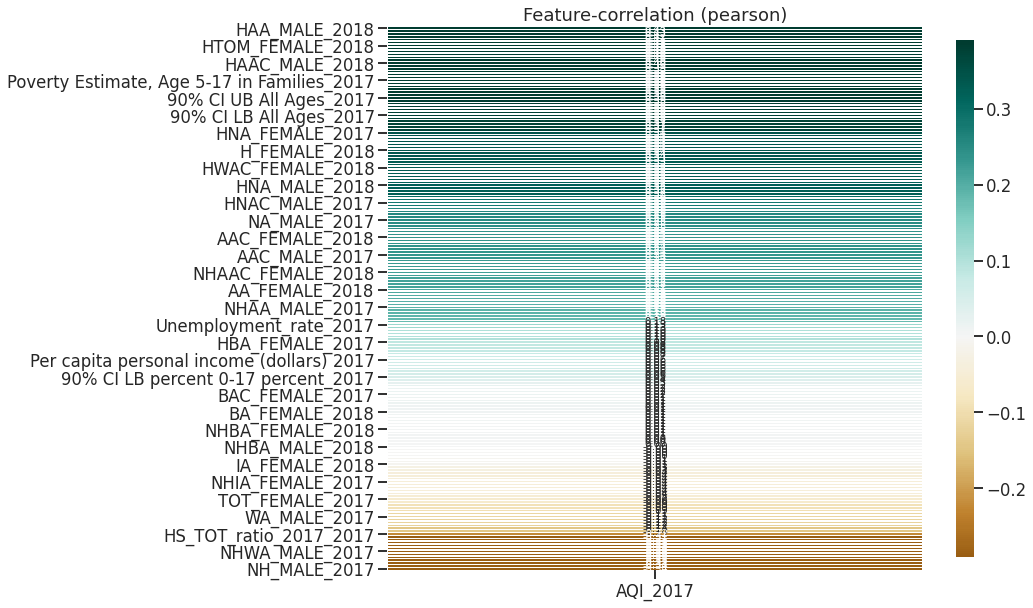

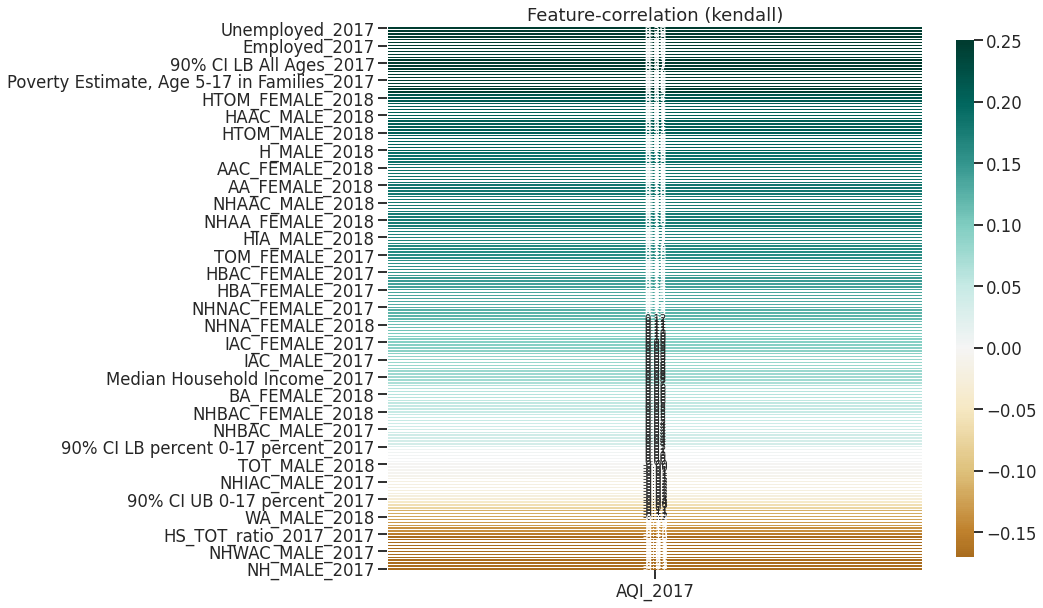

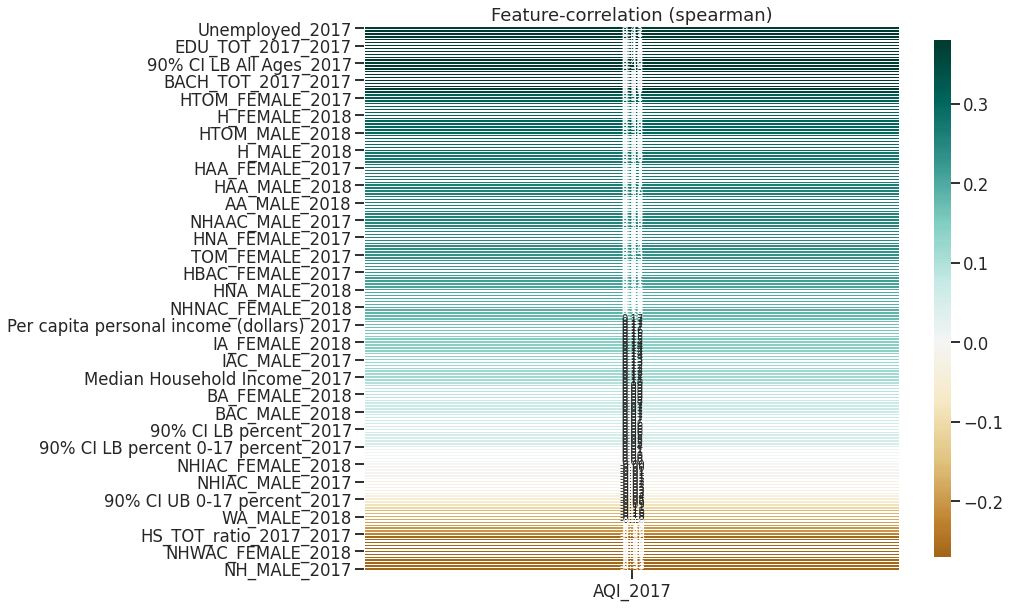

In [657]:
klib.corr_plot(df_2017, target='AQI_2017', method='pearson')
klib.corr_plot(df_2017, target='AQI_2017', method='kendall')
klib.corr_plot(df_2017, target='AQI_2017', method='spearman')

## Try make one df of 2018
* Cleaning for datasets were done in Data_Wrangling4 and Data_Wrangling7 files
* So only transforming datasets into one will work

In [658]:
avg_aqi_2018 = avg_aqi_2017_2019.iloc[:, [0, 1, 2, 4]]

unemploy_col_2018 = list(unemploy_rate_2017_2019.columns[0:1]) + list(unemploy_rate_2017_2019.columns[7:11])
unemploy_rate_2018 = unemploy_rate_2017_2019.loc[:, unemploy_col_2018]

pov_col_2018 = list(pov_rate_2017_2019.columns[0:1]) + list(pov_rate_2017_2019.columns[24:45])
pov_rate_2018 = pov_rate_2017_2019.loc[:, pov_col_2018]

incomes_2018 = county_incomes_2017_2019.iloc[:, [0, 3, 6]]

educ_vehicle_2018_col = list(educ_vehicle_2017_2019.columns[0:1]) + list(educ_vehicle_2017_2019.columns[19:34])
educ_vehicle_2018 = educ_vehicle_2017_2019.loc[:, educ_vehicle_2018_col]

county_dem_ratio_2018_col = list(county_dem_ratio_2017_2019.columns[0:1]) + list(county_dem_ratio_2017_2019.columns[148:293])
county_dem_ratio_2018 = county_dem_ratio_2017_2019.loc[:, county_dem_ratio_2018_col]

In [659]:
avg_aqi_unemploy_2018 = pd.merge(avg_aqi_2018, unemploy_rate_2018, how='inner')
avg_aqi_unemploy_pov_2018 = pd.merge(avg_aqi_unemploy_2018, pov_rate_2018, how='inner')
avg_aqi_unemploy_pov_inc_2018 = pd.merge(avg_aqi_unemploy_pov_2018, incomes_2018, how='inner')
avg_aqi_unemploy_pov_inc_educ_veh_2018 = pd.merge(avg_aqi_unemploy_pov_inc_2018, educ_vehicle_2018, how='inner')
df_2018 = pd.merge(avg_aqi_unemploy_pov_inc_educ_veh_2018, county_dem_ratio_2018, how='inner')

df_2018

,GeoFIPS,State Name,county Name,AQI_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,"Poverty Estimate, All Ages_2018",90% CI LB All Ages_2018,90% CI UB All Ages_2018,"Poverty Percent, All Ages_2018",90% CI LB percent_2018,90% CI UB percent_2018,"Poverty Estimate, Age 0-17_2018",90% CI LB percent 0-17_2018,90% CI UB 0-17_2018,"Poverty Percent, Age 0-17_2018",90% CI LB percent 0-17 percent_2018,90% CI UB 0-17 percent_2018,"Poverty Estimate, Age 5-17 in Families_2018",90% CI LB 5-17 fam_2018,90% CI UB 5-17 fam_2018,"Poverty Percent, Age 5-17 in Families_2018",90% CI LB 5-17 percent_2018,90% CI UB percent 5-17 percent_2018,Median Household Income_2018,90% CI Lower Bound LB medh inc_2018,90% CI UB medh inc_2018,Personal income (thousands of dollars) 2018,Per capita personal income (dollars) 2018,POP_2018,EDU_TOT_2018,LESS_HS_TOT_2018,HS_TOT_2018,COL_OR_ASSOC_TOT_2018,BACH_TOT_2018,GRAD_TOT_2018,VEHICLE_TOT_2018,EDU_TOT_ratio_2018,LESS_HS_TOT_ratio_2018,HS_TOT_ratio_2018,COL_OR_ASSOC_TOT_ratio_2018,BACH_TOT_ratio_2018,GRAD_TOT_ratio_2018,VEHICLE_TOT_ratio_2018,HNAC_FEMALE_2018,TOT_POP_2019,TOT_MALE_2019,TOT_FEMALE_2019,WA_MALE_2019,WA_FEMALE_2019,BA_MALE_2019,BA_FEMALE_2019,IA_MALE_2019,IA_FEMALE_2019,AA_MALE_2019,AA_FEMALE_2019,NA_MALE_2019,NA_FEMALE_2019,TOM_MALE_2019,TOM_FEMALE_2019,WAC_MALE_2019,WAC_FEMALE_2019,BAC_MALE_2019,BAC_FEMALE_2019,IAC_MALE_2019,IAC_FEMALE_2019,AAC_MALE_2019,AAC_FEMALE_2019,NAC_MALE_2019,NAC_FEMALE_2019,NH_MALE_2019,NH_FEMALE_2019,NHWA_MALE_2019,NHWA_FEMALE_2019,NHBA_MALE_2019,NHBA_FEMALE_2019,NHIA_MALE_2019,NHIA_FEMALE_2019,NHAA_MALE_2019,NHAA_FEMALE_2019,NHNA_MALE_2019,NHNA_FEMALE_2019,NHTOM_MALE_2019,NHTOM_FEMALE_2019,NHWAC_MALE_2019,NHWAC_FEMALE_2019,NHBAC_MALE_2019,NHBAC_FEMALE_2019,NHIAC_MALE_2019,NHIAC_FEMALE_2019,NHAAC_MALE_2019,NHAAC_FEMALE_2019,NHNAC_MALE_2019,NHNAC_FEMALE_2019,H_MALE_2019,H_FEMALE_2019,HWA_MALE_2019,HWA_FEMALE_2019,HBA_MALE_2019,HBA_FEMALE_2019,HIA_MALE_2019,HIA_FEMALE_2019,HAA_MALE_2019,HAA_FEMALE_2019,HNA_MALE_2019,HNA_FEMALE_2019,HTOM_MALE_2019,HTOM_FEMALE_2019,HWAC_MALE_2019,HWAC_FEMALE_2019,HBAC_MALE_2019,HBAC_FEMALE_2019,HIAC_MALE_2019,HIAC_FEMALE_2019,HAAC_MALE_2019,HAAC_FEMALE_2019,HNAC_MALE_2019,HNAC_FEMALE_2019
0,01003,Alabama,Baldwin,36.829630,95233,91809,3424,3.6,21069.0,17390.0,24748.0,9.800000,8.1,11.500000,6442.0,4723.0,8161.0,13.900000,10.2,17.600000,4534.0,3223.0,5845.0,13.100000,9.300000,16.9,57588.0,54437.0,60739.0,10065966.0,46205.0,218022,155691.0,15282.0,44013.0,47573.0,32210.0,16613.0,87745,71.410683,7.009384,20.187412,21.820275,14.773738,7.619873,40.245938,0.014230,223234,48.490373,51.509627,42.471129,44.969852,4.249353,4.527536,0.404508,0.375839,0.417499,0.648647,0.033149,0.035837,0.914735,0.951916,43.331213,45.859054,4.634599,4.931148,0.814392,0.799609,0.629384,0.871731,0.080633,0.083769,46.006433,49.274752,40.247005,42.960302,4.169616,4.437944,0.337314,0.337762,0.408092,0.642823,0.023742,0.031357,0.820664,0.864564,41.026905,43.777830,4.514545,4.805272,0.696131,0.711361,0.598475,0.842614,0.055995,0.068090,2.483941,2.234875,2.224124,2.009551,0.079737,0.089592,0.067194,0.038077,0.009407,0.005823,0.009407,0.004480,0.094072,0.087352,2.304308,2.081224,0.120053,0.125877,0.118262,0.088248,0.030909,0.029117,0.024638,0.015679
1,01049,Alabama,DeKalb,36.720000,30289,29153,1136,3.8,14975.0,13282.0,16668.0,21.299999,18.9,23.700001,4990.0,4274.0,5706.0,29.600000,25.4,33.799999,3773.0,3275.0,4271.0,29.600000,25.700001,33.5,39491.0,36085.0,42897.0,2330853.0,32642.0,71385,48169.0,11681.0,14333.0,14995.0,3931.0,3229.0,26150,67.477761,16.363382,20.078448,21.005814,5.506759,4.523359,36.632346,0.261879,71513,49.748997,50.251003,45.963671,46.750940,0.962063,0.911722,1.040370,0.981640,0.278271,0.240516,0.335603,0.271279,1.169018,1.094906,47.075357,47.763344,1.265504,1.195587,1.847217,1.763316,0.378952,0.316026,0.371960,0.324417,41.757443,43.176765,39.178891,40.670927,0.736929,0.741124,0.606883,0.619468,0.198565,0.162208,0.034959,0.029365

* df_2018 contains data on NorthEastern counties of the US
* The columns of df_2018 go from average aqi, unemployment rate, poverty rate, education attainment ratio, total vehicle ratio, demographic ratios

<AxesSubplot:title={'center':'Feature-correlation (spearman)'}>

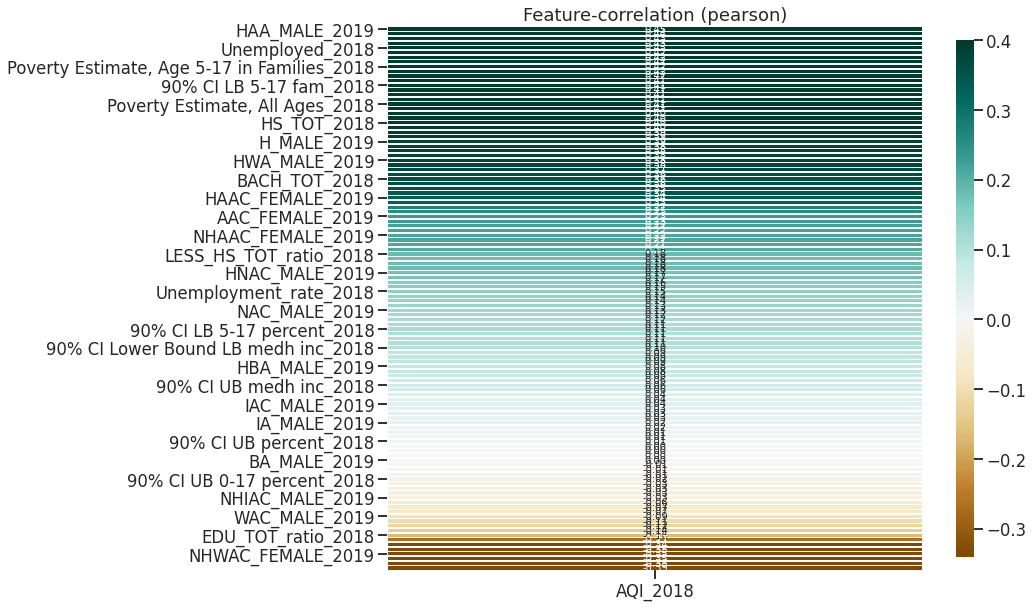

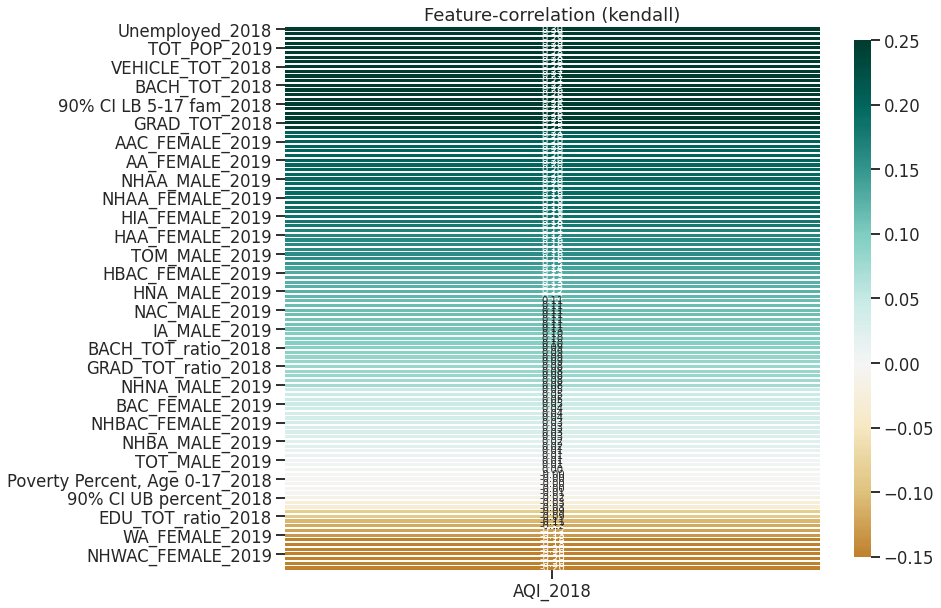

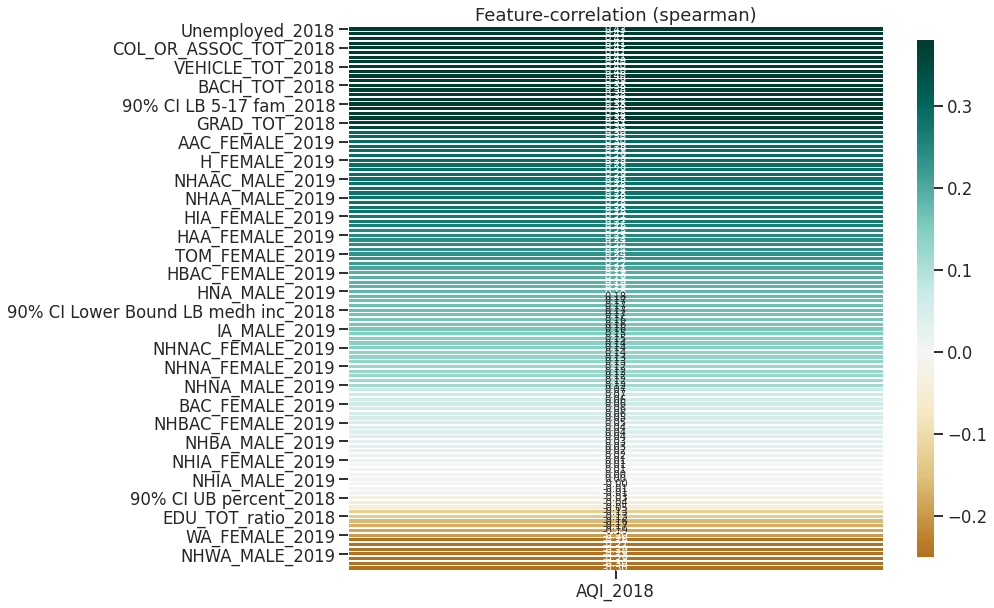

In [660]:
klib.corr_plot(df_2018, target='AQI_2018', method='pearson')
klib.corr_plot(df_2018, target='AQI_2018', method='kendall')
klib.corr_plot(df_2018, target='AQI_2018', method='spearman')

## Try make one df of 2019
* Cleaning for datasets were done in Data_Wrangling4 and Data_Wrangling7 files
* So only transforming datasets into one will work

In [661]:
avg_aqi_2019 = avg_aqi_2017_2019.iloc[:,[0, 1, 2, 5]]

unemploy_col_2019 = list(unemploy_rate_2017_2019.columns[0:1]) + list(unemploy_rate_2017_2019.columns[11:])
unemploy_rate_2019 = unemploy_rate_2017_2019.loc[:, unemploy_col_2019]

pov_col_2019 = list(pov_rate_2017_2019.columns[0:1]) + list(pov_rate_2017_2019.columns[45:])
pov_rate_2019 = pov_rate_2017_2019.loc[:, pov_col_2019]

incomes_2019 = county_incomes_2017_2019.iloc[:, [0, 4, 7]]

educ_vehicle_2019_col = list(educ_vehicle_2017_2019.columns[0:1]) + list(educ_vehicle_2017_2019.columns[34:])
educ_vehicle_2019 = educ_vehicle_2017_2019.loc[:, educ_vehicle_2019_col]

county_dem_ratio_2019_col = list(county_dem_ratio_2017_2019.columns[0:1]) + list(county_dem_ratio_2017_2019.columns[293:])
county_dem_ratio_2019 = county_dem_ratio_2017_2019.loc[:, county_dem_ratio_2019_col]

In [662]:
avg_aqi_unemploy_2019 = pd.merge(avg_aqi_2019, unemploy_rate_2019, how='inner')
avg_aqi_unemploy_pov_2019 = pd.merge(avg_aqi_unemploy_2019, pov_rate_2019, how='inner')
avg_aqi_unemploy_pov_inc_2019 = pd.merge(avg_aqi_unemploy_pov_2019, incomes_2019, how='inner')
avg_aqi_unemploy_pov_inc_educ_veh_2019 = pd.merge(avg_aqi_unemploy_pov_inc_2019, educ_vehicle_2019, how='inner')
df_2019 = pd.merge(avg_aqi_unemploy_pov_inc_educ_veh_2019, county_dem_ratio_2019, how='inner')

df_2019

,GeoFIPS,State Name,county Name,AQI_2019,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,"Poverty Estimate, All Ages_2019",90% CI LB All Ages_2019,90% CI UB All Ages_2019,"Poverty Percent, All Ages_2019",90% CI LB percent_2019,90% CI UB percent_2019,"Poverty Estimate, Age 0-17_2019",90% CI LB percent 0-17_2019,90% CI UB 0-17_2019,"Poverty Percent, Age 0-17_2019",90% CI LB percent 0-17 percent_2019,90% CI UB 0-17 percent_2019,"Poverty Estimate, Age 5-17 in Families_2019",90% CI LB 5-17 fam_2019,90% CI UB 5-17 fam_2019,"Poverty Percent, Age 5-17 in Families_2019",90% CI LB 5-17 percent_2019,90% CI UB percent 5-17 percent_2019,Median Household Income_2019,90% CI Lower Bound LB medh inc_2019,90% CI UB medh inc_2019,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2019,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,01003,Alabama,Baldwin,38.291513,97328,94675,2653,2.7,22360.0,18541.0,26179.0,10.100000,8.400000,11.800000,6323.0,4521.0,8125.0,13.500000,9.600000,17.400000,4641.0,3295.0,5987.0,13.300000,9.400000,17.200001,59871.0,54593.0,65149.0,10600260.0,47485.0,223234,159717.0,15158.0,41884.0,51204.0,32781.0,18690.0,85170,71.546897,6.790184,18.762375,22.937366,14.684591,8.372381,38.152790
1,01049,Alabama,DeKalb,39.711911,31052,30182,870,2.8,12848.0,10674.0,15022.0,18.200001,15.100000,21.299999,4947.0,4070.0,5824.0,29.400000,24.200001,34.599998,3859.0,3231.0,4487.0,30.500000,25.500000,35.500000,44277.0,40315.0,48239.0,2377212.0,33242.0,71513,47007.0,10043.0,17881.0,13084.0,3693.0,2306.0,28065,65.732105,14.043600,25.003845,18.295974,5.164096,3.224589,39.244613
2,01051,Alabama,Elmore,38.421053,37565,36586,979,2.6,8753.0,6975.0,10531.0,11.400000,9.100000,13.700000,3159.0,2393.0,3925.0,17.700001,13.400000,22.000000,2348.0,1767.0,2929.0,17.799999,13.400000,22.200001,62310.0,57594.0,67026.0,3598857.0,44316.0,81209,57553.0,5940.0,19992.0,17311.0,9418.0,4892.0,33005,70.870224,7.314460,24.617961,21.316603,11.597237,6.023963,40.642047
3,01055,Alabama,Etowah,41.666667,42723,41295,1428,3.3,18801.0,16286.0,21316.0,18.799999,16.299999,21.299999,5754.0,4606.0,6902.0,27.000000,21.600000,32.400002,3945.0,2988.0,4902.0,25.600000,19.400000,31.799999,43047.0,39460.0,46634.0,3919481.0,38326.0,102268,71744.0,11380.0,23037.0,24958.0,7524.0,4845.0,38685,70.152932,11.127625,22.526108,24.404506,7.357140,4.737552,37.827082
4,01069,Alabama,Houston,35.585714,46234,44844,1390,3.0,20207.0,18225.0,22189.0,19.400000,17.500000,21.299999,6601.0,5665.0,7537.0,27.799999,23.900000,31.700001,4439.0,3677.0,5201.0,25.700001,21.299999,30.100000,50138.0,47462.0,52814.0,4727293.0,44647.0,105882,73454.0,11010.0,22300.0,23467.0,10453.0,6224.0,39440,69.373453,10.398368,21.061181,22.163352,9.872311,5.878242,37.249013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,55117,Wisconsin,Sheboygan,40.800971,62144,60436,1708,2.7,9051.0,7374.0,10728.0,8.100000,6.600000,9.600000,2816.0,2137.0,3495.0,11.400000,8.700000,14.100000,1877.0,1375.0,2379.0,10.200000,7.500000,12.900000,62108.0,58536.0,65680.0,6309435.0,54703.0,115340,80744.0,4133.0,28075.0,26041.0,16532.0,5963.0,52135,70.005202,3.583319,24.341079,22.577597,14.333276,5.169932,45.201144
580,55127,Wisconsin,Walworth,38.653659,57872,55975,1897,3.3,9532.0,7892.0,11172.0,9.500000,7.900000,11.100000,1916.0,1296.0,2536.0,9.300000,6.300000,12.300000,1321.0,860.0,1782.0,8.400000,5.500000,11.300000,64682.0,60871.0,68493.0,5317609.0,51196.0,103868,69576.0,5887.0,21733.0,20540.0,14250.0,7166.0,45585,66.985019,5.667771,20.923672,19.775099,13.719336,6.899141,43.887434
581,55133,Wisconsin,Waukesha,41.254795,224731,218151,6580,2

* df_2019 contains data on NorthEastern counties of the US
* The columns of df_2019 go from average aqi, unemployment rate, poverty rate, education attainment ratio, total vehicle ratio, demographic ratios

<AxesSubplot:title={'center':'Feature-correlation (spearman)'}>

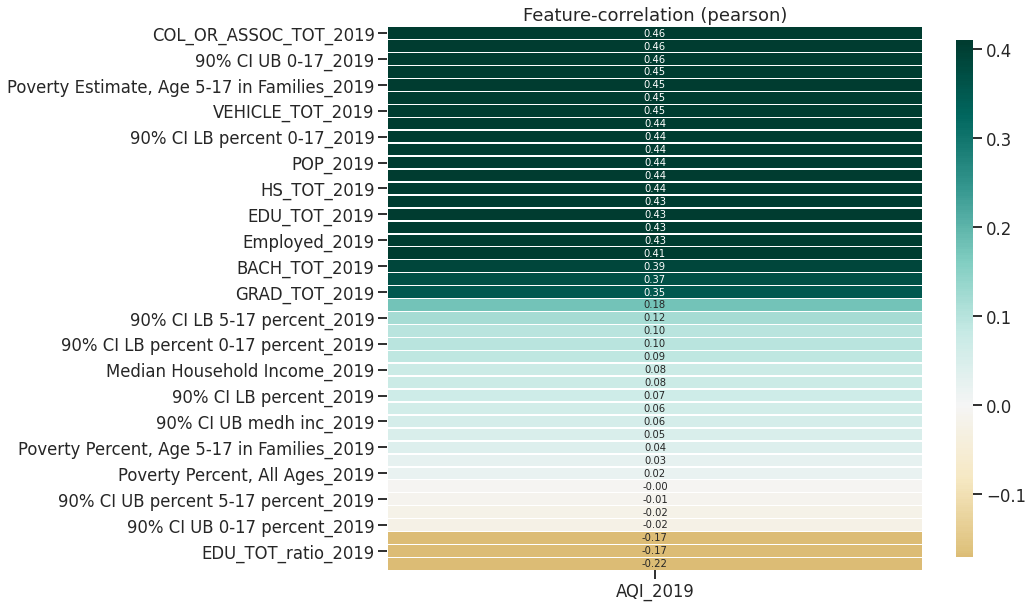

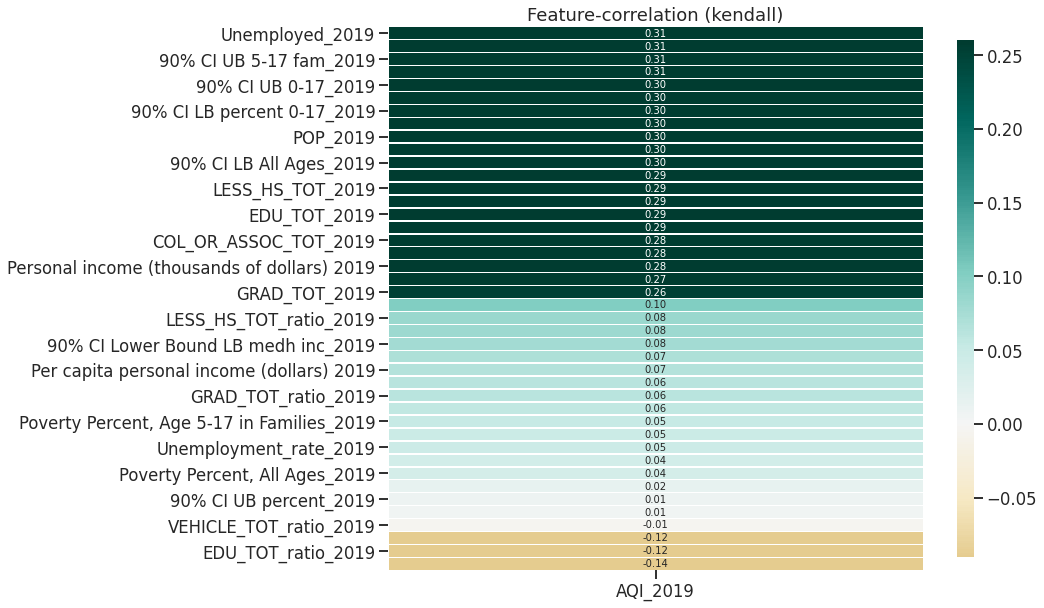

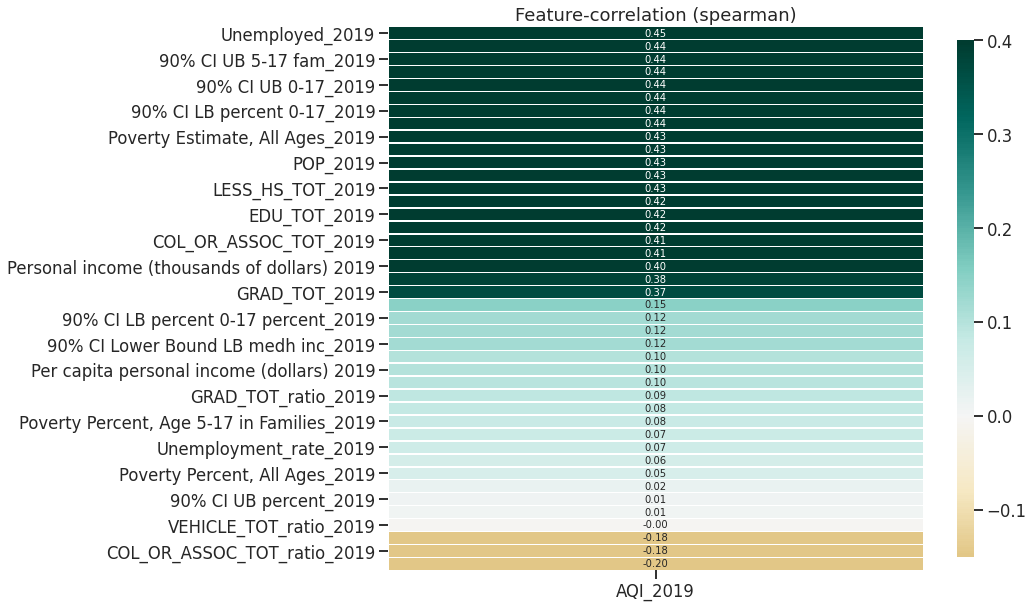

In [663]:
klib.corr_plot(df_2019, target='AQI_2019', method='pearson')
klib.corr_plot(df_2019, target='AQI_2019', method='kendall')
klib.corr_plot(df_2019, target='AQI_2019', method='spearman')

# Merge dataframe into df 2017-2019

In [664]:
pd.set_option('display.max_columns', 200)

df_2017_2018 = pd.merge(df_2017, df_2018, how='inner')
df_2017_2019 = pd.merge(df_2017_2018, df_2019, how='inner')

df_2017_2019

,GeoFIPS,State Name,county Name,AQI_2017,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,"Poverty Estimate, All Ages_2017",90% CI LB All Ages_2017,90% CI UB All Ages_2017,"Poverty Percent, All Ages_2017",90% CI LB percent_2017,90% CI UB percent_2017,"Poverty Estimate, Age 0-17_2017",90% CI LB percent 0-17_2017,90% CI UB 0-17_2017,"Poverty Percent, Age 0-17_2017",90% CI LB percent 0-17 percent_2017,90% CI UB 0-17 percent_2017,"Poverty Estimate, Age 5-17 in Families_2017",90% CI LB 5-17 fam_2017,90% CI UB 5-17 fam_2017,"Poverty Percent, Age 5-17 in Families_2017",90% CI LB 5-17 percent_2017,90% CI UB percent 5-17 percent_2017,Median Household Income_2017,90% CI Lower Bound LB medh inc_2017,90% CI UB medh inc_2017,Personal income (thousands of dollars) 2017,Per capita personal income (dollars) 2017,POP_2017,EDU_TOT_2017_2017,LESS_HS_TOT_2017_2017,HS_TOT_2017_2017,COL_OR_ASSOC_TOT_2017_2017,BACH_TOT_2017_2017,GRAD_TOT_2017_2017,VEHICLE_TOT_2017_2017,EDU_TOT_ratio_2017_2017,LESS_HS_TOT_ratio_2017_2017,HS_TOT_ratio_2017_2017,COL_OR_ASSOC_TOT_ratio_2017_2017,BACH_TOT_ratio_2017_2017,GRAD_TOT_ratio_2017_2017,VEHICLE_TOT_ratio_2017_2017,TOT_POP_2017,TOT_MALE_2017,TOT_FEMALE_2017,WA_MALE_2017,WA_FEMALE_2017,BA_MALE_2017,BA_FEMALE_2017,IA_MALE_2017,IA_FEMALE_2017,AA_MALE_2017,AA_FEMALE_2017,NA_MALE_2017,NA_FEMALE_2017,TOM_MALE_2017,TOM_FEMALE_2017,WAC_MALE_2017,WAC_FEMALE_2017,BAC_MALE_2017,BAC_FEMALE_2017,IAC_MALE_2017,IAC_FEMALE_2017,AAC_MALE_2017,AAC_FEMALE_2017,NAC_MALE_2017,NAC_FEMALE_2017,NH_MALE_2017,NH_FEMALE_2017,NHWA_MALE_2017,NHWA_FEMALE_2017,NHBA_MALE_2017,NHBA_FEMALE_2017,NHIA_MALE_2017,NHIA_FEMALE_2017,NHAA_MALE_2017,NHAA_FEMALE_2017,NHNA_MALE_2017,NHNA_FEMALE_2017,NHTOM_MALE_2017,NHTOM_FEMALE_2017,NHWAC_MALE_2017,NHWAC_FEMALE_2017,NHBAC_MALE_2017,NHBAC_FEMALE_2017,NHIAC_MALE_2017,NHIAC_FEMALE_2017,NHAAC_MALE_2017,NHAAC_FEMALE_2017,NHNAC_MALE_2017,NHNAC_FEMALE_2017,H_MALE_2017,H_FEMALE_2017,HWA_MALE_2017,HWA_FEMALE_2017,HBA_MALE_2017,...,WAC_FEMALE_2019,BAC_MALE_2019,BAC_FEMALE_2019,IAC_MALE_2019,IAC_FEMALE_2019,AAC_MALE_2019,AAC_FEMALE_2019,NAC_MALE_2019,NAC_FEMALE_2019,NH_MALE_2019,NH_FEMALE_2019,NHWA_MALE_2019,NHWA_FEMALE_2019,NHBA_MALE_2019,NHBA_FEMALE_2019,NHIA_MALE_2019,NHIA_FEMALE_2019,NHAA_MALE_2019,NHAA_FEMALE_2019,NHNA_MALE_2019,NHNA_FEMALE_2019,NHTOM_MALE_2019,NHTOM_FEMALE_2019,NHWAC_MALE_2019,NHWAC_FEMALE_2019,NHBAC_MALE_2019,NHBAC_FEMALE_2019,NHIAC_MALE_2019,NHIAC_FEMALE_2019,NHAAC_MALE_2019,NHAAC_FEMALE_2019,NHNAC_MALE_2019,NHNAC_FEMALE_2019,H_MALE_2019,H_FEMALE_2019,HWA_MALE_2019,HWA_FEMALE_2019,HBA_MALE_2019,HBA_FEMALE_2019,HIA_MALE_2019,HIA_FEMALE_2019,HAA_MALE_2019,HAA_FEMALE_2019,HNA_MALE_2019,HNA_FEMALE_2019,HTOM_MALE_2019,HTOM_FEMALE_2019,HWAC_MALE_2019,HWAC_FEMALE_2019,HBAC_MALE_2019,HBAC_FEMALE_2019,HIAC_MALE_2019,HIAC_FEMALE_2019,HAAC_MALE_2019,HAAC_FEMALE_2019,HNAC_MALE_2019,HNAC_FEMALE_2019,AQI_2019,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,"Poverty Estimate, All Ages_2019",90% CI LB All Ages_2019,90% CI UB All Ages_2019,"Poverty Percent, All Ages_2019",90% CI LB percent_2019,90% CI UB percent_2019,"Poverty Estimate, Age 0-17_2019",90% CI LB percent 0-17_2019,90% CI UB 0-17_2019,"Poverty Percent, Age 0-17_2019",90% CI LB percent 0-17 percent_2019,90% CI UB 0-17 percent_2019,"Poverty Estimate, Age 5-17 in Families_2019",90% CI LB 5-17 fam_2019,90% CI UB 5-17 fam_2019,"Poverty Percent, Age 5-17 in Families_2019",90% CI LB 5-17 percent_2019,90% CI UB percent 5-17 percent_2019,Median Household Income_2019,90% CI Lower Bound LB medh inc_2019,90% CI UB medh inc_2019,Personal income (thousands of dollars) 2019,Per capita personal income (dollars) 2019,POP_2019,EDU_TOT_2019,LESS_HS_TOT_2019,HS_TOT_2019,COL_OR_ASSOC_TOT_2019,BACH_TOT_2019,GRAD_TOT_2019,VEHICLE_TOT_2019,EDU_TOT_ratio_2019,LESS_HS_TOT_ratio_2019,HS_TOT_ratio_2019,COL_OR_ASSOC_TOT_ratio_2019,BACH_TOT_ratio_2019,GRAD_TOT_ratio_2019,VEHICLE_TOT_ratio_2019
0,01003,Alabama,Baldwin

# save data


In [665]:
# save 2017-2019 dataset
data_path = r'../../data/processed/all_df_2017_2019'
df_2017_2019.to_csv(data_path, index=False)

# save datasets for individual years
data_path = r'../../data/processed/all_df_2017'
df_2017.to_csv(data_path, index=False)
data_path = r'../../data/processed/all_df_2018'
df_2018.to_csv(data_path, index=False)
data_path = r'../../data/processed/all_df_2019'
df_2019.to_csv(data_path, index=False)

In [666]:
display(df_2017.corr()['AQI_2017'].sort_values().tail(15))
display(df_2018.corr()['AQI_2018'].sort_values().tail(15))
display(df_2019.corr()['AQI_2019'].sort_values().tail(15))

HAAC_FEMALE_2018              0.394392
HAAC_MALE_2018                0.395218
HAAC_MALE_2017                0.396267
HAAC_FEMALE_2017              0.396299
HTOM_MALE_2018                0.398170
Unemployed_2017               0.400028
HTOM_MALE_2017                0.401997
HTOM_FEMALE_2018              0.405102
HTOM_FEMALE_2017              0.407280
COL_OR_ASSOC_TOT_2017_2017    0.410468
HAA_FEMALE_2017               0.424264
HAA_FEMALE_2018               0.425032
HAA_MALE_2017                 0.434679
HAA_MALE_2018                 0.435753
AQI_2017                      1.000000
Name: AQI_2017, dtype: float64

90% CI LB percent 0-17_2018                    0.412860
90% CI LB 5-17 fam_2018                        0.413311
TOT_POP_2019                                   0.414052
VEHICLE_TOT_2018                               0.415882
Poverty Estimate, Age 0-17_2018                0.416369
Poverty Estimate, Age 5-17 in Families_2018    0.417630
90% CI UB 0-17_2018                            0.419139
HIAC_MALE_2019                                 0.420466
90% CI UB 5-17 fam_2018                        0.420985
Unemployed_2018                                0.426408
HAA_FEMALE_2019                                0.429569
HIAC_FEMALE_2019                               0.430216
COL_OR_ASSOC_TOT_2018                          0.436336
HAA_MALE_2019                                  0.445701
AQI_2018                                       1.000000
Name: AQI_2018, dtype: float64

90% CI LB All Ages_2019                        0.433041
HS_TOT_2019                                    0.435163
Poverty Estimate, All Ages_2019                0.437551
POP_2019                                       0.440995
90% CI UB All Ages_2019                        0.441500
90% CI LB percent 0-17_2019                    0.443038
90% CI LB 5-17 fam_2019                        0.444072
VEHICLE_TOT_2019                               0.449706
Poverty Estimate, Age 0-17_2019                0.450030
Poverty Estimate, Age 5-17 in Families_2019    0.452129
Unemployed_2019                                0.452189
90% CI UB 0-17_2019                            0.455602
90% CI UB 5-17 fam_2019                        0.458400
COL_OR_ASSOC_TOT_2019                          0.462045
AQI_2019                                       1.000000
Name: AQI_2019, dtype: float64